## Imports

In [458]:
#!pip install kneed
#!pip install pyreadstat
#!pip install statsmodels

In [459]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random

from scipy import stats
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import (adjusted_rand_score, mutual_info_score,
                             silhouette_score, adjusted_mutual_info_score)
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             confusion_matrix, accuracy_score, classification_report)
from sklearn.metrics import mutual_info_score
from sklearn.metrics import silhouette_score
from scipy.stats import chi2_contingency

from transformers import AutoTokenizer, AutoModelForCausalLM, GPT2Tokenizer, GPT2LMHeadModel

import plotly.express as px
import statsmodels.stats.multitest
from kneed import KneeLocator

import pickle
import itertools

warnings.filterwarnings('ignore')


In [460]:
#from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Approach

### Accompanying notebooks


* 'Preprocessing survey scores - Mijntje.ipynb' - preprocessing the WVS dataset (WVS_Moral) and PEW dataset and acquiring the WVS and PEW moral scores, saved at 'MyDrive/MSc Applied Data Science/ADS thesis Mijntje/WVS_moral_scores.csv' & 'MyDrive/MSc Applied Data Science/ADS thesis Mijntje/PEW_moral_scores.csv'

* "Final code all models - Mijntje.ipynb" - probing the LLMs and getting the model moral scores, files saved in 'MyDrive/MSc Applied Data Science/ADS thesis Mijntje/Mijn data'

### Load in preprocessed WVS scores

In [461]:
# load in WVS scores, preprocessed in notebook Preprocessing survey scores - Mijntje.ipynb

WVS_df = pd.read_csv('/content/drive/MyDrive/MSc Applied Data Science/ADS thesis Mijntje/WVS_moral_scores.csv')

WVS_preprocessed_df = WVS_df.pivot(index='country', columns='topic', values='wvs_score')

# Define the desired column order
column_order = [
    'claiming government benefits to which you are not entitled',
    'avoiding a fare on public transport',
    'stealing property',
    'cheating on taxes',
    'someone accepting a bribe in the course of their duties',
    'homosexuality',
    'prostitution',
    'abortion',
    'divorce',
    'sex before marriage',
    'suicide',
    'euthanasia',
    'for a man to beat his wife',
    'parents beating children',
    'violence against other people',
    'terrorism as a political, ideological or religious mean',
    'having casual sex',
    'political violence',
    'death penalty'
]

# Reorder columns
WVS_preprocessed_df = WVS_preprocessed_df[column_order]


In [462]:
# take a look at the WVS ground truth moral scores per country

WVS_preprocessed_df.head()

topic       claiming government benefits to which you are not entitled  \
country                                                                  
Andorra                                             -0.778001            
Argentina                                           -0.208916            
Armenia                                             -0.808106            
Australia                                           -0.826899            
Bangladesh                                          -0.772407            

topic       avoiding a fare on public transport  stealing property  \
country                                                              
Andorra                               -0.802617          -0.887670   
Argentina                             -0.544523          -0.837911   
Armenia                               -0.909282          -0.969714   
Australia                             -0.732066          -0.910814   
Bangladesh                            -0.822037          -0.876852   

topic       cheating on taxes  \
country                         
Andorra             -0.849706   
Argentina           -0.746418   
Armenia             -0.852156   
Australia           -0.811403   
Bangladesh          -0.844259   

topic       someone accepting a bribe in the course of their duties  \
country                                                               
Andorra                                             -0.932068         
Argentina                                           -0.805387         
Armenia                                             -0.937449         
Australia                                           -0.903328         
Bangladesh                                          -0.865000         

topic       homosexuality  prostitution  abortion   divorce  \
country                                                       
Andorra          0.561117     -0.170013  0.127572  0.609778   
Argentina        0.116314     -0.351227 -0.415500  0.229020   
Armenia         -0.917125     -0.919875 -0.669831 -0.419681   
Australia        0.419493     -0.072584  0.236072  0.497393   
Bangladesh      -0.847222     -0.866667 -0.772963 -0.740000   

topic       sex before marriage   suicide  euthanasia  \
country                                                 
Andorra                0.598170 -0.413778    0.152512   
Argentina              0.275352 -0.630502   -0.364970   
Armenia               -0.667961 -0.930247   -0.675446   
Australia              0.529924 -0.324791    0.264172   
Bangladesh            -0.887778 -0.800000   -0.605000   

topic       for a man to beat his wife  parents beating children  \
country                                                            
Andorra                      -0.954712                 -0.846461   
Argentina                    -0.902151                 -0.790061   
Armenia                      -0.945310                 -0.797482   
Australia                    -0.946369                 -0.864880   
Bangladesh                   -0.796667                 -0.743148   

topic       violence against other people  \
country                                     
Andorra                         -0.934132   
Argentina                       -0.838710   
Armenia                         -0.939974   
Australia                       -0.867636   
Bangladesh                      -0.823519   

topic       terrorism as a political, ideological or religious mean  \
country                                                               
Andorra                                             -0.972444         
Argentina                                           -0.865128         
Armenia                                             -0.946844         
Australia                                           -0.928452         
Bangladesh                                          -0.823333         

topic       having casual sex  political violence  death penalty  
country                                                     

### Load in preprocessed PEW scores

In [463]:
# load in WVS scores, preprocessed in notebook Preprocessing survey scores.ipynb

PEW_df = pd.read_csv('/content/drive/MyDrive/MSc Applied Data Science/ADS thesis Mijntje/PEW_moral_scores.csv')

PEW_preprocessed_df = PEW_df.pivot(index='country', columns='topic', values='pew_score')

column_order = ['using contraceptives',
                'getting a divorce',
                'having an abortion',
                'homosexuality',
                'drinking alcohol',
                'married people having an affair',
                'gambling',
                'sex between unmarried adults']

# Reorder columns
PEW_preprocessed_df = PEW_preprocessed_df[column_order]

In [464]:
# take a look at the WVS ground truth moral scores per country

PEW_preprocessed_df.head()

topic      using contraceptives  getting a divorce  having an abortion  \
country                                                                  
Argentina              0.632479           0.438339           -0.382173   
Australia              0.567500           0.402500            0.080000   
Bolivia                0.391250          -0.188750           -0.770000   
Brazil                 0.709375           0.375000           -0.723958   
Britain                0.597826           0.328063            0.018775   

topic      homosexuality  drinking alcohol  married people having an affair  \
country                                                                       
Argentina       0.201465         -0.136752                        -0.592186   
Australia       0.172500          0.300000                        -0.751250   
Bolivia        -0.198750         -0.572500                        -0.782500   
Brazil          0.052083         -0.175000                        -0.779167   
Britain         0.174901          0.292490                        -0.704545   

topic      gambling  sex between unmarried adults  
country                                            
Argentina -0.274725                      0.222222  
Australia -0.156250                      0.245000  
Bolivia   -0.507500                     -0.326250  
Brazil    -0.495833                      0.123958  
Britain   -0.047431                      0.249012

### Models

In [465]:
models = ['gpt2-medium', 'gpt2-large', 'OPT-125', 'QWEN', 'BLOOM']
lms = ['gpt2-medium', 'gpt2-large', 'OPT-125', 'QWEN', 'BLOOM']
lms_names = ['gpt2-medium', 'gpt2-large', 'OPT-125', 'QWEN','BLOOM']

## Part 1. Comparing variation between countries on survey and model scores for moral topics


### Variation comparison

#### WVS

In [505]:
# compare cross-country variation on topics between original WVS moral scores & model-generated moral scores

variation_rows = []

for model in models:

  for topic in WVS_preprocessed_df.columns:

    wvs_scores = WVS_preprocessed_df[topic]

    # the below .csv file was generated using 'Definitieve kopie van Models Final.ipynb', and it has for each model the average of the model-generated moral score for 'in' and 'people' prompting mode, using all token pairs and taking the mean for both prompting modes

    model_df = pd.read_csv(f'/content/drive/MyDrive/MSc Applied Data Science/ADS thesis Mijntje/Mijn data/wvs_w7_{model}_token_pairs_BOTH-MIJNTJE-FINAL.csv')

    # TODO: change to normalized log prob difference

    model_scores = model_df.loc[model_df['topic'] == topic]['average normalized log prob']

    wvs_var = np.var(wvs_scores.values)
    wvs_mean = np.mean(wvs_scores.values)
    model_var = np.var(model_scores.values)
    model_mean = np.mean(model_scores.values)

    row = {'dataname': "WVS", 'model': model, 'WVS variation': wvs_var, 'WVS mean': wvs_mean, 'model variation': model_var, 'model mean': model_mean, 'topic': topic}
    variation_rows.append(row)

df = pd.DataFrame(variation_rows)
df

dataname        model  WVS variation  WVS mean  model variation  \
0       WVS  gpt2-medium       0.050250 -0.548660         0.006521   
1       WVS  gpt2-medium       0.050506 -0.577708         0.012787   
2       WVS  gpt2-medium       0.015135 -0.823498         0.008894   
3       WVS  gpt2-medium       0.020463 -0.731677         0.016437   
4       WVS  gpt2-medium       0.018882 -0.787300         0.004620   
..      ...          ...            ...       ...              ...   
90      WVS        BLOOM       0.015286 -0.793133         0.001551   
91      WVS        BLOOM       0.030471 -0.810569         0.009127   
92      WVS        BLOOM       0.122007 -0.452386         0.002305   
93      WVS        BLOOM       0.029183 -0.773062         0.002342   
94      WVS        BLOOM       0.078559 -0.321548         0.003646   

    model mean                                              topic  
0     0.742067  claiming government benefits to which you are ...  
1     0.672883                avoiding a fare on public transport  
2     0.668511                                  stealing property  
3     0.377471                                  cheating on taxes  
4     0.665916  someone accepting a bribe in the course of the...  
..         ...                                                ...  
90    0.568232                      violence against other people  
91   -0.408084  terrorism as a political, ideological or relig...  
92    0.421751                                  having casual sex  
93    0.462985                                 political violence  
94    0.831519                                      death penalty  

[95 rows x 7 columns]

In [506]:
def draw_model(models, dataset):
    list_rows = []
    fig, axes = plt.subplots(1, len(models), figsize=(3 * len(models), 2), sharey=False, sharex=True)
    plt.subplots_adjust(wspace = 0.4, hspace=0.8)

    if dataset == 'WVS':
      topics_list = list(WVS_preprocessed_df.columns)

    elif dataset == 'PEW':
      topics_list = list(PEW_preprocessed_df.columns)

    topic_mapping = {topic: f'{i + 1}) {topic}' for i, topic in enumerate(topics_list)}

    for i, model in enumerate(models):
        # Get the corresponding model name
        model_name = lms_names[lms.index(model)]

        # Filter the DataFrame for the specific model
        model_df = df[df.model == model_name]

        # Plotting
        ax = axes[i]
        g = sns.regplot(data=model_df, x=f'{dataset} variation', y='model variation', ax=ax, color='grey')
        g = sns.scatterplot(data=model_df, x=f'{dataset} variation', y='model variation', hue='topic', ax=ax, legend=True)

        ax.set_ylabel('Model variation')
        ax.set_xlabel(f'Empirical {dataset} survey variation')
        ax.set_title(model_name)
        ax.legend().remove()

        for _, row in model_df.iterrows():
            x = row[f'{dataset} variation']
            y = row['model variation']
            s = topics_list.index(row['topic']) + 1
            ax.text(x=x, y=y, s=s)

        slope, intercept, r_value, p_value, std_err = stats.linregress(model_df['model variation'], model_df[f'{dataset} variation'])
        row = {'model': model_name, 'r': round(r_value, 3), 'p': round(p_value, 3)}
        list_rows.append(row)

        sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)

    handles, labels = axes[0].get_legend_handles_labels()
    new_labels = [f'{i + 1}) {label}' for i, label in enumerate(labels)]
    #fig.legend(handles, new_labels,  loc='center left', bbox_to_anchor=(0.92, 0.5), fontsize='large')

    return list_rows

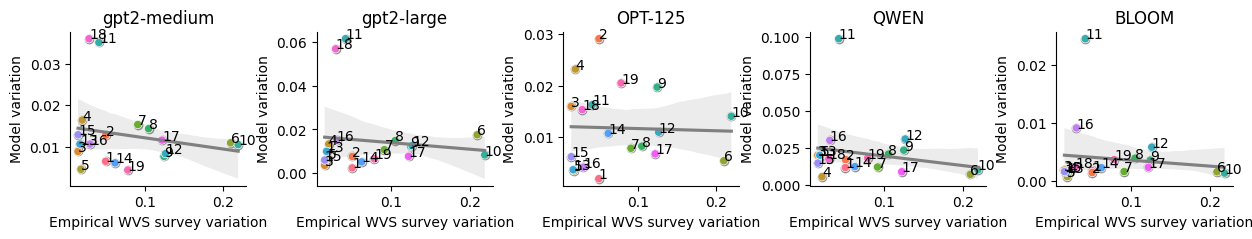

In [507]:
list_rows = draw_model(models, 'WVS')

#TODO: normalize plots / get on the same scale? --> check: paper also didn't do that, points might not be visible then

##### Test differences between variations for significance with correlation

In [508]:
df_list_rows = pd.DataFrame(list_rows)
df_list_rows['corrected p'] = statsmodels.stats.multitest.multipletests(df_list_rows['p'], alpha=0.05, method='bonferroni', \
                                                              is_sorted=False, returnsorted=False)[1]
display(df_list_rows)

model      r      p  corrected p
0  gpt2-medium -0.195  0.424          1.0
1   gpt2-large -0.115  0.640          1.0
2      OPT-125 -0.035  0.887          1.0
3         QWEN -0.200  0.413          1.0
4        BLOOM -0.118  0.631          1.0

##### Calculate means for moral score and variation score

In [509]:
# Calculate the mean of the WVS moral scores for all topics
wvs_mean_all_topics = df['WVS mean'].mean()

# Calculate the mean scores for each model across all topics
model_means = df.groupby('model')['model mean'].mean().reset_index()

# Add the WVS mean for all topics to the model means DataFrame
wvs_mean_df = pd.DataFrame({'model': ['WVS'], 'model mean': [wvs_mean_all_topics]})

# Concatenate the WVS mean with the model means
results = pd.concat([wvs_mean_df, model_means], ignore_index=True)

results = results.rename(columns={"model": "source", "model mean": "mean moral score"})

# Display the resulting DataFrame
display(results)

source  mean moral score
0          WVS         -0.575995
1        BLOOM          0.473576
2      OPT-125          0.104104
3         QWEN          0.241515
4   gpt2-large          0.322543
5  gpt2-medium          0.411380

In [510]:
# Calculate the mean of the WVS variation scores for all topics
wvs_mean_all_topics = df['WVS variation'].mean()

# Calculate the mean scores for each model across all topics
model_means = df.groupby('model')['model variation'].mean().reset_index()

# Add the WVS mean for all topics to the model means DataFrame
wvs_mean_df = pd.DataFrame({'model': ['WVS'], 'model variation': [wvs_mean_all_topics]})

# Concatenate the WVS mean with the model means
results = pd.concat([wvs_mean_df, model_means], ignore_index=True)

results = results.rename(columns={"model": "source", "model variation": "mean variation score"})

# Display the resulting DataFrame
display(results)

source  mean variation score
0          WVS              0.075163
1        BLOOM              0.003785
2      OPT-125              0.011770
3         QWEN              0.021157
4   gpt2-large              0.014663
5  gpt2-medium              0.012844

##### Zoom in on top k most controversial & agreed on topics

In [511]:
topic_variations = df[['WVS variation', 'topic']][:19]

#display(topic_variations)

# top k most controversial topics according to WVS survey & their variance scores

most_controversial_WVS = topic_variations.nlargest(3, 'WVS variation')
print("Top 3 most controversial topics:")
display(most_controversial_WVS)


# top k most agreed upon topics & their variance scores

most_agreed_on_WVS = topic_variations.nsmallest(3, 'WVS variation')
print("Top 3 most agreed on topics:")
display(most_agreed_on_WVS)


Top 3 most controversial topics:


WVS variation                topic
9        0.218995  sex before marriage
5        0.209379        homosexuality
11       0.126444           euthanasia

Top 3 most agreed on topics:


WVS variation                          topic
2        0.015135              stealing property
14       0.015286  violence against other people
12       0.017651     for a man to beat his wife

In [515]:
for model in models:

  topic_variations = df.loc[df['model'] == model][['model', 'model variation', 'topic']]

  # top k most controversial topics according to WVS survey & their variance scores

  most_controversial_model = topic_variations.nlargest(3, 'model variation')
  print(f"Top 3 most controversial topics {model}:")
  display(most_controversial_model)


  # top k most agreed upon topics & their variance scores

  most_agreed_on_model = topic_variations.nsmallest(3, 'model variation')
  print(f"Top 3 most agreed on topics {model}:")
  display(most_agreed_on_model)

  print("\n")

Top 3 most controversial topics gpt2-medium:


model  model variation               topic
17  gpt2-medium         0.035984  political violence
10  gpt2-medium         0.035085             suicide
3   gpt2-medium         0.016437   cheating on taxes

Top 3 most agreed on topics gpt2-medium:


model  model variation  \
18  gpt2-medium         0.004426   
4   gpt2-medium         0.004620   
13  gpt2-medium         0.006140   

                                                topic  
18                                      death penalty  
4   someone accepting a bribe in the course of the...  
13                           parents beating children



Top 3 most controversial topics gpt2-large:


model  model variation               topic
29  gpt2-large         0.061594             suicide
36  gpt2-large         0.056970  political violence
24  gpt2-large         0.017554       homosexuality

Top 3 most agreed on topics gpt2-large:


model  model variation  \
19  gpt2-large         0.002376   
21  gpt2-large         0.003559   
32  gpt2-large         0.005124   

                                                topic  
19  claiming government benefits to which you are ...  
21                                  stealing property  
32                           parents beating children



Top 3 most controversial topics OPT-125:


model  model variation                                topic
39  OPT-125         0.029136  avoiding a fare on public transport
41  OPT-125         0.023232                    cheating on taxes
56  OPT-125         0.020532                        death penalty

Top 3 most agreed on topics OPT-125:


model  model variation  \
38  OPT-125         0.001912   
42  OPT-125         0.003456   
50  OPT-125         0.003651   

                                                topic  
38  claiming government benefits to which you are ...  
42  someone accepting a bribe in the course of the...  
50                         for a man to beat his wife



Top 3 most controversial topics QWEN:


model  model variation                                              topic
67  QWEN         0.098742                                            suicide
68  QWEN         0.031091                                         euthanasia
72  QWEN         0.030206  terrorism as a political, ideological or relig...

Top 3 most agreed on topics QWEN:


model  model variation              topic
60  QWEN         0.005685  cheating on taxes
62  QWEN         0.007282      homosexuality
73  QWEN         0.009043  having casual sex



Top 3 most controversial topics BLOOM:


model  model variation                                              topic
86  BLOOM         0.024608                                            suicide
91  BLOOM         0.009127  terrorism as a political, ideological or relig...
87  BLOOM         0.005798                                         euthanasia

Top 3 most agreed on topics BLOOM:


model  model variation                                              topic
80  BLOOM         0.000686  someone accepting a bribe in the course of the...
85  BLOOM         0.001291                                sex before marriage
77  BLOOM         0.001388                avoiding a fare on public transport

In [513]:
# what do models get most wrong? i.e. the biggest difference between survey variation and model variation

# highlights the topics where the models' estimation of country variation are most inaccurate compared to the actual WVS data

model_order = models

# Add a new column for the difference
df['variation difference'] = (df['WVS variation'] - df['model variation']).abs()

# Define the number of top topics you want to get
k = 5

# Get the top k topics for each model
top_k_topics = df.groupby('model').apply(lambda x: x.nlargest(k, 'variation difference')).reset_index(drop=True)

top_k_topics_ordered = top_k_topics.set_index('model').loc[model_order].reset_index()

top_k_topics_ordered
# model says there is little variation (i.e. people agree on this topic), while there actually is a lot of variation (i.e. it's a controversial topic): homosexuality & sex before marriage

model dataname  WVS variation  WVS mean  model variation  \
0   gpt2-medium      WVS       0.218995 -0.244216         0.010535   
1   gpt2-medium      WVS       0.209379 -0.396388         0.010971   
2   gpt2-medium      WVS       0.126444 -0.429912         0.008378   
3   gpt2-medium      WVS       0.124605 -0.150266         0.007694   
4   gpt2-medium      WVS       0.122007 -0.452386         0.011622   
5    gpt2-large      WVS       0.218995 -0.244216         0.008319   
6    gpt2-large      WVS       0.209379 -0.396388         0.017554   
7    gpt2-large      WVS       0.122007 -0.452386         0.007668   
8    gpt2-large      WVS       0.126444 -0.429912         0.012559   
9    gpt2-large      WVS       0.124605 -0.150266         0.012290   
10      OPT-125      WVS       0.218995 -0.244216         0.014064   
11      OPT-125      WVS       0.209379 -0.396388         0.005413   
12      OPT-125      WVS       0.126444 -0.429912         0.010965   
13      OPT-125      WVS       0.122007 -0.452386         0.006743   
14      OPT-125      WVS       0.124605 -0.150266         0.019739   
15         QWEN      WVS       0.218995 -0.244216         0.010392   
16         QWEN      WVS       0.209379 -0.396388         0.007282   
17         QWEN      WVS       0.122007 -0.452386         0.009043   
18         QWEN      WVS       0.124605 -0.150266         0.023604   
19         QWEN      WVS       0.126444 -0.429912         0.031091   
20        BLOOM      WVS       0.218995 -0.244216         0.001291   
21        BLOOM      WVS       0.209379 -0.396388         0.001530   
22        BLOOM      WVS       0.124605 -0.150266         0.003560   
23        BLOOM      WVS       0.126444 -0.429912         0.005798   
24        BLOOM      WVS       0.122007 -0.452386         0.002305   

    model mean                topic  variation difference  
0     0.464507  sex before marriage              0.208460  
1     0.576535        homosexuality              0.198407  
2     0.481128           euthanasia              0.118065  
3     0.217067              divorce              0.116911  
4     0.370956    having casual sex              0.110385  
5     0.453757  sex before marriage              0.210676  
6    -0.086370        homosexuality              0.191824  
7     0.469612    having casual sex              0.114339  
8     0.260637           euthanasia              0.113884  
9     0.120595              divorce              0.112315  
10    0.475488  sex before marriage              0.204931  
11    0.255381        homosexuality              0.203965  
12    0.012983           euthanasia              0.115479  
13    0.092764    having casual sex              0.115264  
14   -0.261389              divorce              0.104866  
15    0.414781  sex before marriage              0.208603  
16    0.465536        homosexuality              0.202096  
17    0.177105    having casual sex              0.112965  
18   -0.042016              divorce              0.101001  
19   -0.115451           euthanasia              0.095352  
20    0.662204  sex before marriage              0.217704  
21    0.864596        homosexuality              0.207849  
22    0.569035              divorce              0.121045  
23    0.711784           euthanasia              0.120646  
24    0.421751    having casual sex              0.119702

#### PEW

In [475]:
# compare cross-country variation on topics between original WVS moral scores & model-generated moral scores

variation_rows = []

for model in models:

  for topic in PEW_preprocessed_df.columns:

    pew_scores = PEW_preprocessed_df[topic]

    # the below .csv file was generated using 'Definitieve kopie van Models Final.ipynb', and it has for each model the average of the model-generated moral score for 'in' and 'people' prompting mode, using all token pairs and taking the mean for both prompting modes

    model_df = pd.read_csv(f'/content/drive/MyDrive/MSc Applied Data Science/ADS thesis Mijntje/Mijn data/PEW_{model}_token_pairs_BOTH-MIJNTJE-FINAL.csv')

    # TODO: change to normalized log prob difference

    model_scores = model_df.loc[model_df['topic'] == topic]['average normalized log prob']

    pew_var = np.var(pew_scores.values)
    pew_mean = np.mean(pew_scores.values)
    model_var = np.var(model_scores.values)
    model_mean = np.mean(model_scores.values)

    row = {'dataname': "PEW", 'model': model, 'PEW variation': pew_var, 'PEW mean': pew_mean, 'model variation': model_var, 'model mean': model_mean, 'topic': topic}
    variation_rows.append(row)

df = pd.DataFrame(variation_rows)
df

#TODO: compare with original paper, did they also find such small variation with the models compared to the survey (a.k.a. models predict kinda the same thing for different countries?)

dataname        model  PEW variation  PEW mean  model variation  \
0       PEW  gpt2-medium       0.085892  0.355377         0.015788   
1       PEW  gpt2-medium       0.131490  0.076062         0.043433   
2       PEW  gpt2-medium       0.130064 -0.404863         0.013409   
3       PEW  gpt2-medium       0.216320 -0.342084         0.015629   
4       PEW  gpt2-medium       0.157193 -0.234491         0.019324   
5       PEW  gpt2-medium       0.021123 -0.715911         0.019667   
6       PEW  gpt2-medium       0.097406 -0.469995         0.039498   
7       PEW  gpt2-medium       0.267761 -0.219045         0.023462   
8       PEW   gpt2-large       0.085892  0.355377         0.022516   
9       PEW   gpt2-large       0.131490  0.076062         0.042921   
10      PEW   gpt2-large       0.130064 -0.404863         0.014515   
11      PEW   gpt2-large       0.216320 -0.342084         0.033382   
12      PEW   gpt2-large       0.157193 -0.234491         0.022527   
13      PEW   gpt2-large       0.021123 -0.715911         0.023063   
14      PEW   gpt2-large       0.097406 -0.469995         0.037800   
15      PEW   gpt2-large       0.267761 -0.219045         0.058616   
16      PEW      OPT-125       0.085892  0.355377         0.040670   
17      PEW      OPT-125       0.131490  0.076062         0.037541   
18      PEW      OPT-125       0.130064 -0.404863         0.022098   
19      PEW      OPT-125       0.216320 -0.342084         0.018719   
20      PEW      OPT-125       0.157193 -0.234491         0.030916   
21      PEW      OPT-125       0.021123 -0.715911         0.010641   
22      PEW      OPT-125       0.097406 -0.469995         0.032281   
23      PEW      OPT-125       0.267761 -0.219045         0.019941   
24      PEW         QWEN       0.085892  0.355377         0.006344   
25      PEW         QWEN       0.131490  0.076062         0.042902   
26      PEW         QWEN       0.130064 -0.404863         0.003560   
27      PEW         QWEN       0.216320 -0.342084         0.007132   
28      PEW         QWEN       0.157193 -0.234491         0.044229   
29      PEW         QWEN       0.021123 -0.715911         0.005547   
30      PEW         QWEN       0.097406 -0.469995         0.026500   
31      PEW         QWEN       0.267761 -0.219045         0.014968   
32      PEW        BLOOM       0.085892  0.355377         0.006045   
33      PEW        BLOOM       0.131490  0.076062         0.002192   
34      PEW        BLOOM       0.130064 -0.404863         0.004426   
35      PEW        BLOOM       0.216320 -0.342084         0.002889   
36      PEW        BLOOM       0.157193 -0.234491         0.005594   
37      PEW        BLOOM       0.021123 -0.715911         0.004327   
38      PEW        BLOOM       0.097406 -0.469995         0.004015   
39      PEW        BLOOM       0.267761 -0.219045         0.019864   

    model mean                            topic  
0     0.719953             using contraceptives  
1    -0.251430                getting a divorce  
2     0.519618               having an abortion  
3     0.641471                    homosexuality  
4     0.141957                 drinking alcohol  
5     0.351914  married people having an affair  
6    -0.355089                         gambling  
7     0.043747     sex between unmarried adults  
8     0.545359             using contraceptives  
9    -0.203483                getting a divorce  
10    0.370908               having an abortion  
11   -0.188458                    homosexuality  
12    0.209639                 drinking alcohol  
13    0.518639  married people having an affair  
14    0.166233                         gambling  
15   -0.138021     sex between unmarried adults  
16    0.290766             using contraceptives  
17   -0.051181                getting a divorce  
18    0.365733               having an abortion  
19    0.569555                    homosexuality  
20    0.187410                 drinking alcohol  
21    0.309282  married people h

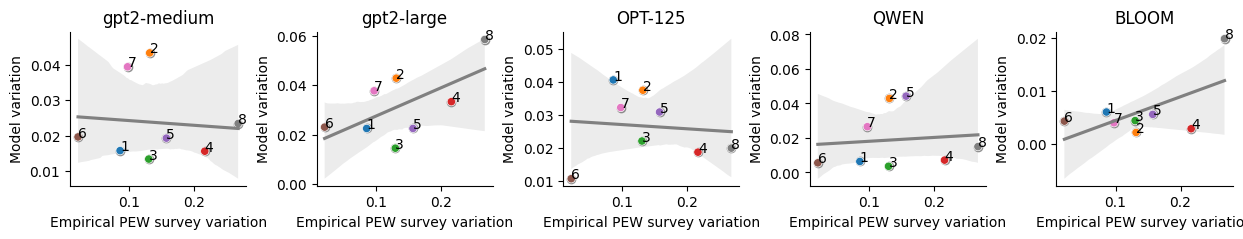

In [476]:
list_rows = draw_model(models, 'PEW')

#TODO: normalize plots / get on the same scale?

##### Test differences between variations for significance with correlation

In [477]:
df_list_rows = pd.DataFrame(list_rows)
display(df_list_rows)
df_list_rows['corrected p'] = statsmodels.stats.multitest.multipletests(df_list_rows['p'], alpha=0.05, method='bonferroni', \
                                                              is_sorted=False, returnsorted=False)[1]

model      r      p
0  gpt2-medium -0.090  0.832
1   gpt2-large  0.617  0.103
2      OPT-125 -0.095  0.822
3         QWEN  0.102  0.811
4        BLOOM  0.608  0.110

In [478]:
df_list_rows

model      r      p  corrected p
0  gpt2-medium -0.090  0.832        1.000
1   gpt2-large  0.617  0.103        0.515
2      OPT-125 -0.095  0.822        1.000
3         QWEN  0.102  0.811        1.000
4        BLOOM  0.608  0.110        0.550

##### Calculate means for moral score and variation score

In [479]:
# Calculate the mean of the PEW moral scores for all topics
pew_mean_all_topics = df['PEW mean'].mean()

# Calculate the mean scores for each model across all topics
model_means = df.groupby('model')['model mean'].mean().reset_index()

# Add the PEW mean for all topics to the model means DataFrame
pew_mean_df = pd.DataFrame({'model': ['PEW'], 'model mean': [pew_mean_all_topics]})

# Concatenate the PEW mean with the model means
results = pd.concat([pew_mean_df, model_means], ignore_index=True)

results = results.rename(columns={"model": "source", "model mean": "mean moral score"})

# Display the resulting DataFrame
display(results)

source  mean moral score
0          PEW         -0.244369
1        BLOOM          0.246118
2      OPT-125          0.247627
3         QWEN          0.221191
4   gpt2-large          0.160102
5  gpt2-medium          0.226518

In [480]:
# Calculate the mean of the PEW scores for all topics
pew_mean_all_topics = df['PEW variation'].mean()

# Calculate the mean scores for each model across all topics
model_means = df.groupby('model')['model variation'].mean().reset_index()

# Add the PEW mean for all topics to the model means DataFrame
pew_mean_df = pd.DataFrame({'model': ['PEW'], 'model variation': [pew_mean_all_topics]})

# Concatenate the PEW mean with the model means
results = pd.concat([pew_mean_df, model_means], ignore_index=True)

results = results.rename(columns={"model": "source", "model variation": "mean variation score"})

# Display the resulting DataFrame
display(results)

source  mean variation score
0          PEW              0.138406
1        BLOOM              0.006169
2      OPT-125              0.026601
3         QWEN              0.018898
4   gpt2-large              0.031917
5  gpt2-medium              0.023776

##### Zoom in on top k most controversial & agreed on topics

In [481]:
topic_variations = df[['PEW variation', 'topic']][:8]

# top k most controversial topics according to PEW survey & their variance scores

most_controversial_PEW = topic_variations.nlargest(3, 'PEW variation')
print("Top 3 most controversial topics:")
display(most_controversial_PEW)

# top k most agreed upon topics & their variance scores

most_agreed_on_PEW = topic_variations.nsmallest(3, 'PEW variation')
print("Top 3 most agreed on topics:")
display(most_agreed_on_PEW)


Top 3 most controversial topics:


PEW variation                         topic
7       0.267761  sex between unmarried adults
3       0.216320                 homosexuality
4       0.157193              drinking alcohol

Top 3 most agreed on topics:


PEW variation                            topic
5       0.021123  married people having an affair
0       0.085892             using contraceptives
6       0.097406                         gambling

In [482]:
for model in models:

  topic_variations = df.loc[df['model'] == model][['model', 'model variation', 'topic']]

  # top k most controversial topics according to WVS survey & their variance scores

  most_controversial_model = topic_variations.nlargest(3, 'model variation')
  print(f"Top 5 most controversial topics {model}:")
  display(most_controversial_model)


  # top k most agreed upon topics & their variance scores

  most_agreed_on_model = topic_variations.nsmallest(3, 'model variation')
  print(f"Top 5 most agreed on topics {model}:")
  display(most_agreed_on_model)

  print("\n")


Top 5 most controversial topics gpt2-medium:


model  model variation                         topic
1  gpt2-medium         0.043433             getting a divorce
6  gpt2-medium         0.039498                      gambling
7  gpt2-medium         0.023462  sex between unmarried adults

Top 5 most agreed on topics gpt2-medium:


model  model variation                 topic
2  gpt2-medium         0.013409    having an abortion
3  gpt2-medium         0.015629         homosexuality
0  gpt2-medium         0.015788  using contraceptives



Top 5 most controversial topics gpt2-large:


model  model variation                         topic
15  gpt2-large         0.058616  sex between unmarried adults
9   gpt2-large         0.042921             getting a divorce
14  gpt2-large         0.037800                      gambling

Top 5 most agreed on topics gpt2-large:


model  model variation                 topic
10  gpt2-large         0.014515    having an abortion
8   gpt2-large         0.022516  using contraceptives
12  gpt2-large         0.022527      drinking alcohol



Top 5 most controversial topics OPT-125:


model  model variation                 topic
16  OPT-125         0.040670  using contraceptives
17  OPT-125         0.037541     getting a divorce
22  OPT-125         0.032281              gambling

Top 5 most agreed on topics OPT-125:


model  model variation                            topic
21  OPT-125         0.010641  married people having an affair
19  OPT-125         0.018719                    homosexuality
23  OPT-125         0.019941     sex between unmarried adults



Top 5 most controversial topics QWEN:


model  model variation              topic
28  QWEN         0.044229   drinking alcohol
25  QWEN         0.042902  getting a divorce
30  QWEN         0.026500           gambling

Top 5 most agreed on topics QWEN:


model  model variation                            topic
26  QWEN         0.003560               having an abortion
29  QWEN         0.005547  married people having an affair
24  QWEN         0.006344             using contraceptives



Top 5 most controversial topics BLOOM:


model  model variation                         topic
39  BLOOM         0.019864  sex between unmarried adults
32  BLOOM         0.006045          using contraceptives
36  BLOOM         0.005594              drinking alcohol

Top 5 most agreed on topics BLOOM:


model  model variation              topic
33  BLOOM         0.002192  getting a divorce
35  BLOOM         0.002889      homosexuality
38  BLOOM         0.004015           gambling

In [483]:
# what do models get most wrong? i.e. the biggest difference between survey variation and model variation

# highlights the topics where the models' estimation of country variation are most inaccurate compared to the actual WVS data

model_order = models

# Add a new column for the difference
df['variation difference'] = (df['PEW variation'] - df['model variation']).abs()

# Define the number of top topics you want to get
k = 3

# Get the top k topics for each model
top_k_topics = df.groupby('model').apply(lambda x: x.nlargest(k, 'variation difference')).reset_index(drop=True)

top_k_topics_ordered = top_k_topics.set_index('model').loc[model_order].reset_index()

top_k_topics_ordered

model dataname  PEW variation  PEW mean  model variation  \
0   gpt2-medium      PEW       0.267761 -0.219045         0.023462   
1   gpt2-medium      PEW       0.216320 -0.342084         0.015629   
2   gpt2-medium      PEW       0.157193 -0.234491         0.019324   
3    gpt2-large      PEW       0.267761 -0.219045         0.058616   
4    gpt2-large      PEW       0.216320 -0.342084         0.033382   
5    gpt2-large      PEW       0.157193 -0.234491         0.022527   
6       OPT-125      PEW       0.267761 -0.219045         0.019941   
7       OPT-125      PEW       0.216320 -0.342084         0.018719   
8       OPT-125      PEW       0.157193 -0.234491         0.030916   
9          QWEN      PEW       0.267761 -0.219045         0.014968   
10         QWEN      PEW       0.216320 -0.342084         0.007132   
11         QWEN      PEW       0.130064 -0.404863         0.003560   
12        BLOOM      PEW       0.267761 -0.219045         0.019864   
13        BLOOM      PEW       0.216320 -0.342084         0.002889   
14        BLOOM      PEW       0.157193 -0.234491         0.005594   

    model mean                         topic  variation difference  
0     0.043747  sex between unmarried adults              0.244299  
1     0.641471                 homosexuality              0.200691  
2     0.141957              drinking alcohol              0.137869  
3    -0.138021  sex between unmarried adults              0.209145  
4    -0.188458                 homosexuality              0.182938  
5     0.209639              drinking alcohol              0.134666  
6     0.511863  sex between unmarried adults              0.247820  
7     0.569555                 homosexuality              0.197601  
8     0.187410              drinking alcohol              0.126277  
9     0.494031  sex between unmarried adults              0.252793  
10    0.562481                 homosexuality              0.209188  
11    0.129690            having an abortion              0.126504  
12    0.373956  sex between unmarried adults              0.247896  
13    0.842705                 homosexuality              0.213431  
14    0.159307              drinking alcohol              0.151599

## Part 2. Clustering countries on moral scores & assessing cluster alignment
In this part, we're comparing the clusters generated from the WVS scores with the clusters generated from the LM scores to see how well they align


In [484]:
# Step 1: cluster countries based on which are most similar, taking into account moral scores for all topics, using K-means clustering

# Step 2: use the same method of clustering for the model scores

# Step 3: compare clustering alignment

In [485]:
models = ['gpt2-medium', 'gpt2-large', 'OPT-125', 'QWEN', 'BLOOM']


### Defining functions

In [486]:
# original function but with Ayoub & Hadi's PCA feedback points: explained variance

def find_optimal_k(data, max_k=10):
    silhouette_scores = []
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
        score = silhouette_score(data, kmeans.labels_)
        silhouette_scores.append(score)
    optimal_k = np.argmax(silhouette_scores) + 2  # Adding 2 because range starts at 2
    return optimal_k, silhouette_scores

def find_optimal_pca_components(data, variance_threshold=0.95):
    pca = PCA().fit(data)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    optimal_components = np.argmax(cumulative_variance >= variance_threshold) + 1
    return optimal_components, cumulative_variance

def cluster_and_compare(preprocessed_df, dataset, models=None, mode='', variance_threshold=0.95):
    survey_data = np.array(preprocessed_df)
    optimal_k_survey, _ = find_optimal_k(survey_data, max_k=10)
    print(f'Optimal k for survey data: {optimal_k_survey}')
    kmeans_survey = KMeans(n_clusters=optimal_k_survey, random_state=0).fit(survey_data)
    labels_survey = kmeans_survey.labels_

    optimal_components, cumulative_variance = find_optimal_pca_components(survey_data, variance_threshold=variance_threshold)
    print(f'Optimal number of PCA components: {optimal_components}')
    pca = PCA(n_components=optimal_components)
    survey_data_2d = pca.fit_transform(survey_data)
    explained_variance_total = np.sum(pca.explained_variance_ratio_) * 100

    plt.figure(figsize=(14, 10))
    sns.scatterplot(x=survey_data_2d[:, 0], y=survey_data_2d[:, 1], hue=labels_survey, palette='viridis', s=100)
    for i, country in enumerate(list(preprocessed_df.index)):
        plt.text(survey_data_2d[i, 0], survey_data_2d[i, 1] + 0.005, country, fontsize=9, ha='center', va='top')
    plt.title(f'{dataset} survey data clusters {mode} (Explained variance: {explained_variance_total:.2f}%)')
    plt.xlabel(f'PCA Component 1 ({pca.explained_variance_ratio_[0] * 100:.2f}% variance)')
    plt.ylabel(f'PCA Component 2 ({pca.explained_variance_ratio_[1] * 100:.2f}% variance)')
    plt.legend(title='Cluster')
    plt.show()

    if models:
        for model in models:
            print(f"Model: {model}")

            if dataset == 'WVS':
              model_df = pd.read_csv(f'/content/drive/MyDrive/MSc Applied Data Science/ADS thesis Mijntje/Mijn data/wvs_w7_{model}_token_pairs_BOTH-MIJNTJE-FINAL.csv')

            elif dataset == 'PEW':
              model_df = pd.read_csv(f'/content/drive/MyDrive/MSc Applied Data Science/ADS thesis Mijntje/Mijn data/PEW_{model}_token_pairs_BOTH-MIJNTJE-FINAL.csv')

            model_df = model_df.pivot(index='country', columns='topic', values='average normalized log prob')
            model_df.columns.name = None
            model_df.reset_index(inplace=True)
            model_df.set_index('country', inplace=True)
            columns_order = preprocessed_df.columns
            model_df = model_df[columns_order]
            llm_responses = np.array(model_df)
            kmeans_llm = KMeans(n_clusters=optimal_k_survey, random_state=0).fit(llm_responses)
            labels_llm = kmeans_llm.labels_

            ari = adjusted_rand_score(labels_survey, labels_llm)
            ami = adjusted_mutual_info_score(labels_survey, labels_llm)
            print(f"Adjusted Rand Index: {round(ari, 3)}")
            print(f"Adjusted Mutual Information: {round(ami, 3)}")
            print((f"Combined Alignment Score: {round(((ari + ami) / 2),3)}"))

            llm_responses_2d = pca.fit_transform(llm_responses)
            explained_variance_llm = pca.explained_variance_ratio_
            explained_variance_llm_total = np.sum(explained_variance_llm[:2]) * 100

            plt.figure(figsize=(14, 10))
            sns.scatterplot(x=llm_responses_2d[:, 0], y=llm_responses_2d[:, 1], hue=labels_llm, palette='viridis', s=100)
            for i, country in enumerate(list(preprocessed_df.index)):
                plt.text(llm_responses_2d[i, 0], llm_responses_2d[i, 1] + 0.005, country, fontsize=9, ha='center', va='top')
            plt.title(f'{model}-generated data clusters {mode} (Explained variance: {explained_variance_llm_total:.2f}%)')
            plt.xlabel(f'PCA Component 1 ({explained_variance_llm[0] * 100:.2f}% variance)')
            plt.ylabel(f'PCA Component 2 ({explained_variance_llm[1] * 100:.2f}% variance)')
            plt.legend(title='Cluster')
            plt.show()


### WVS

#### Result 1: all topics together

Optimal k for survey data: 2
Optimal number of PCA components: 8


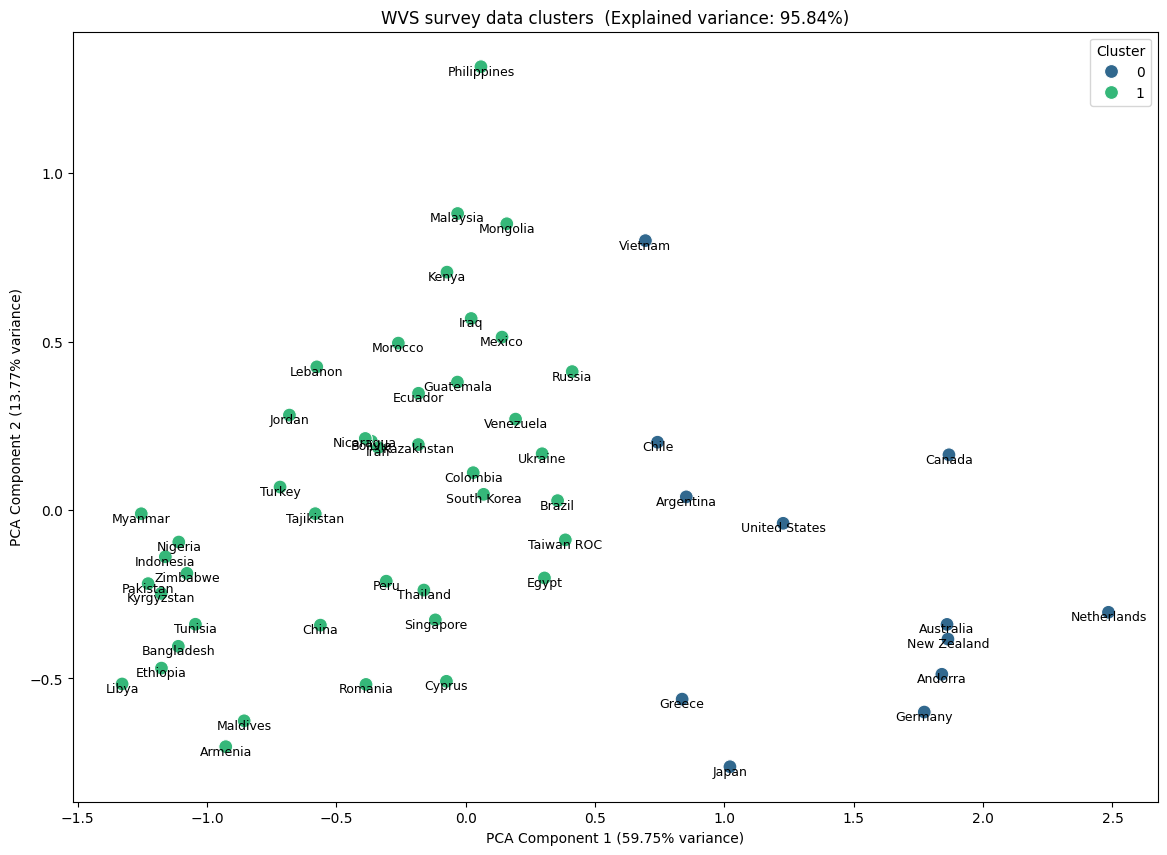

Model: gpt2-medium
Adjusted Rand Index: -0.012
Adjusted Mutual Information: -0.002
Combined Alignment Score: -0.007


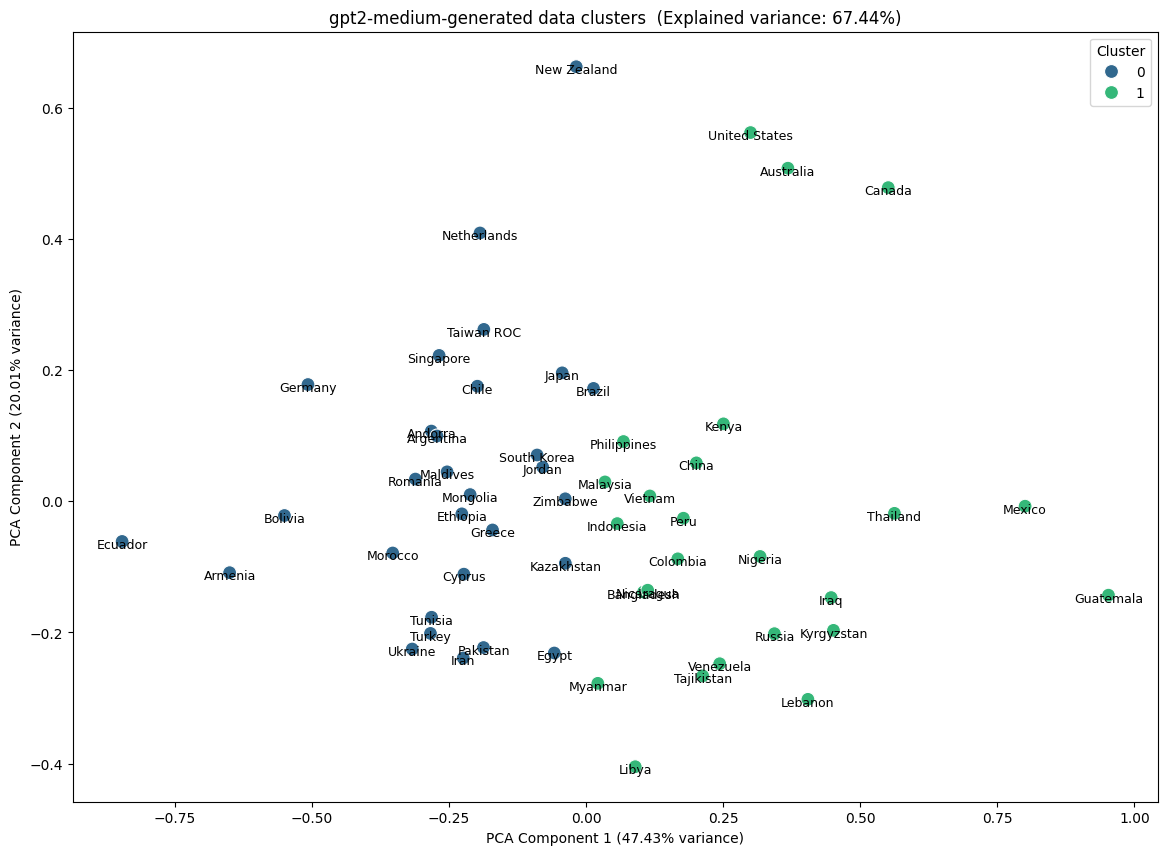

Model: gpt2-large
Adjusted Rand Index: 0.028
Adjusted Mutual Information: 0.04
Combined Alignment Score: 0.034


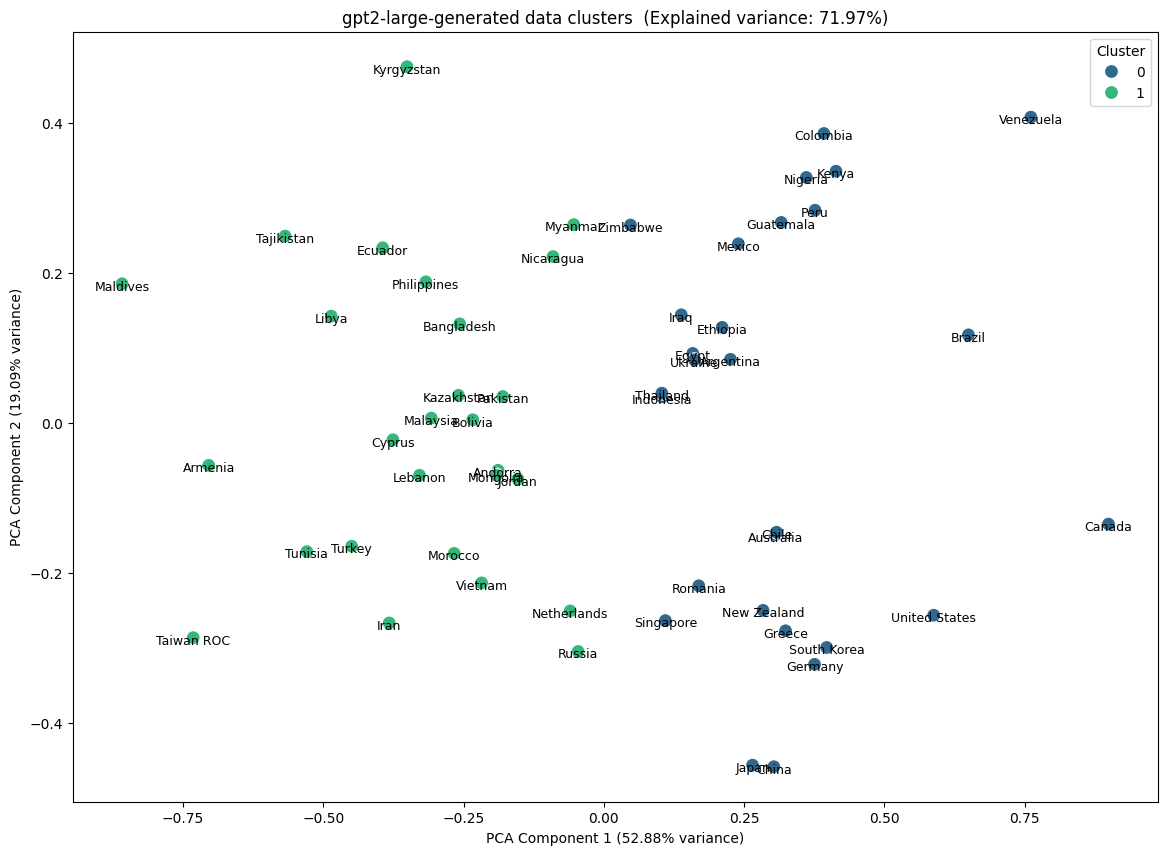

Model: OPT-125
Adjusted Rand Index: -0.073
Adjusted Mutual Information: 0.037
Combined Alignment Score: -0.018


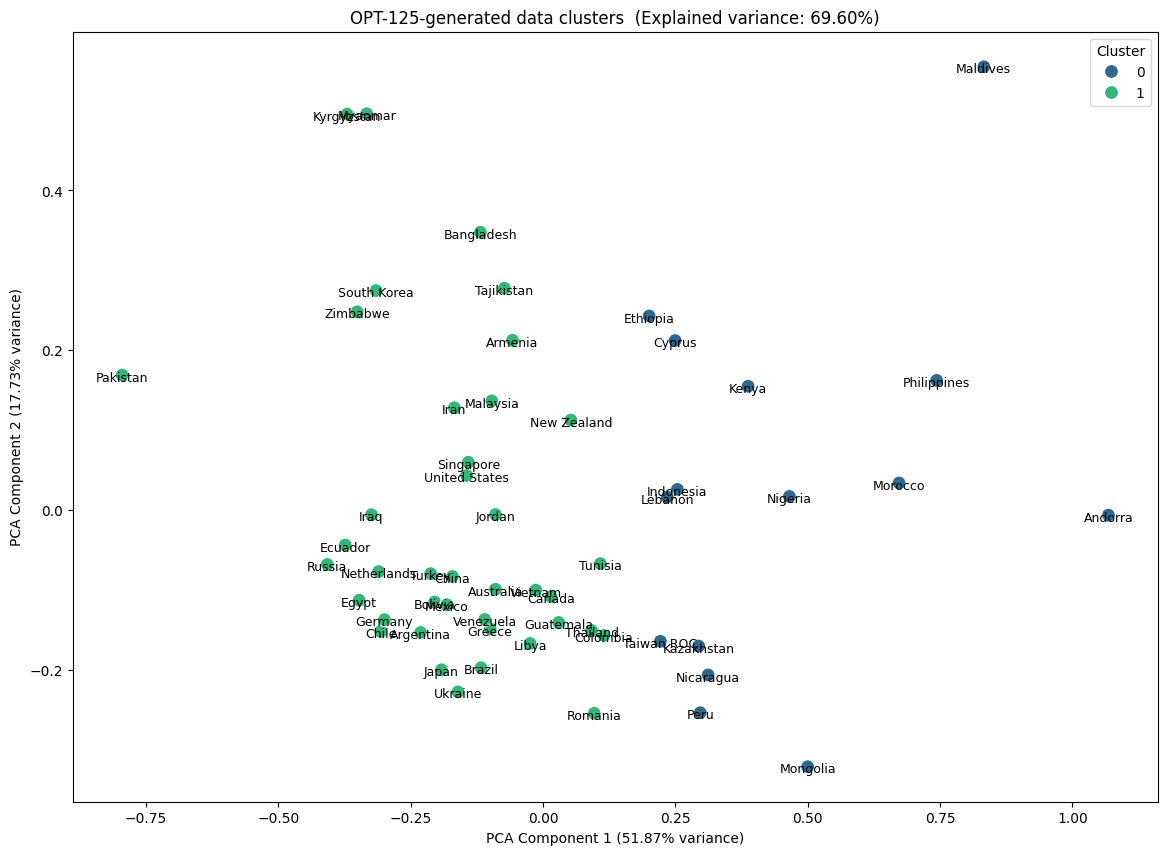

Model: QWEN
Adjusted Rand Index: 0.291
Adjusted Mutual Information: 0.138
Combined Alignment Score: 0.215


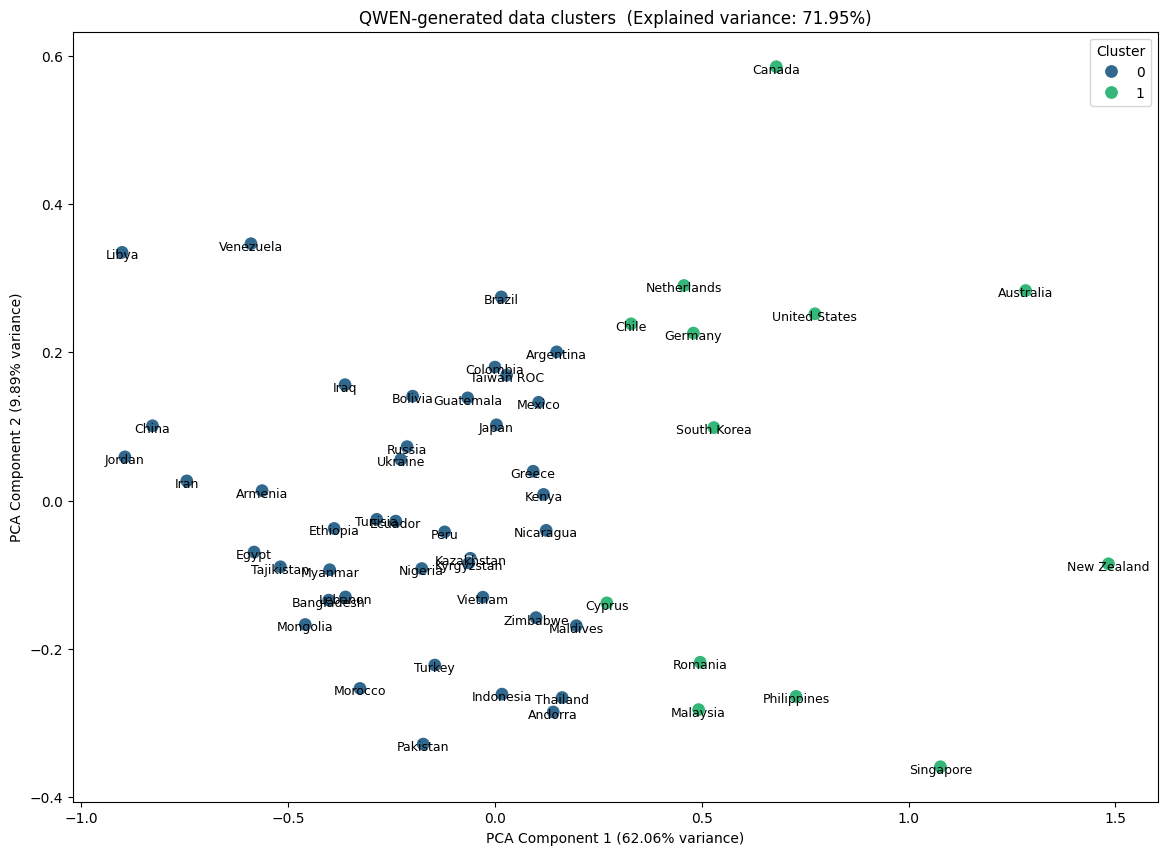

Model: BLOOM
Adjusted Rand Index: 0.015
Adjusted Mutual Information: -0.011
Combined Alignment Score: 0.002


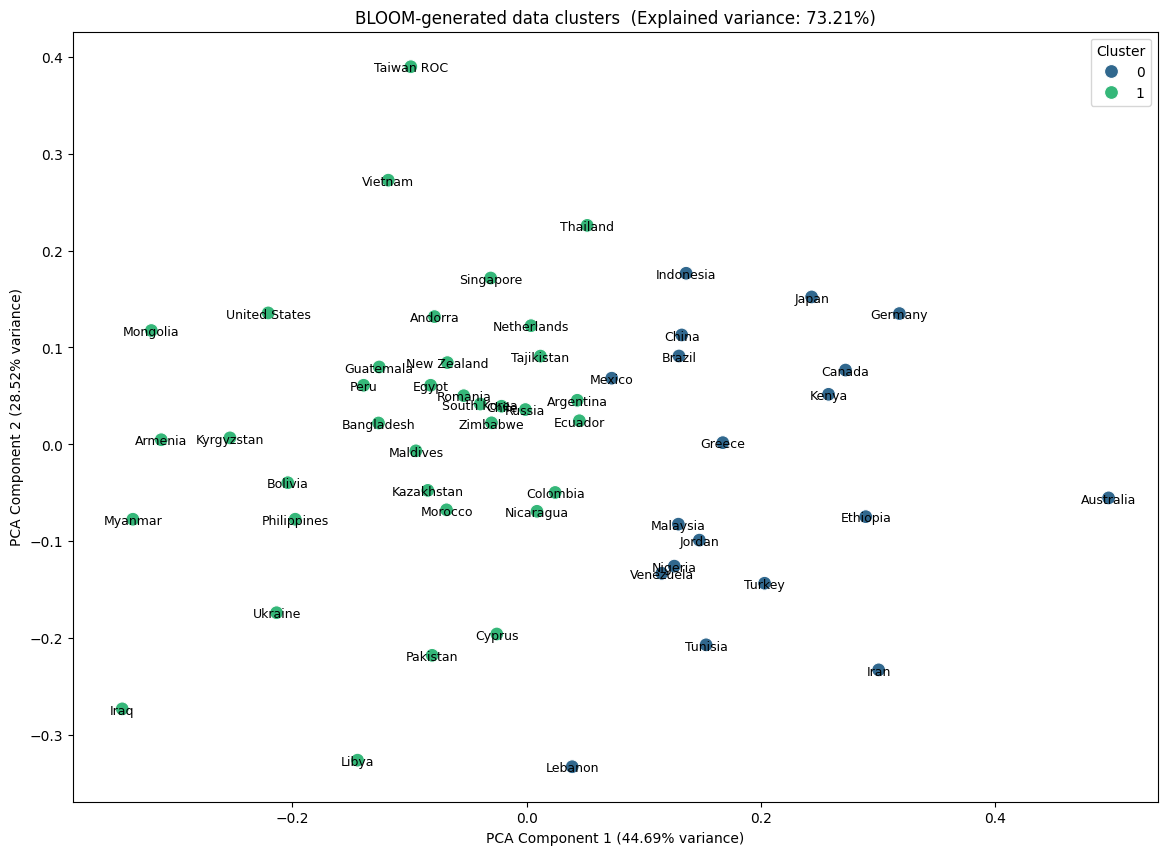

In [487]:
cluster_and_compare(WVS_preprocessed_df, 'WVS', models)

#### Result 2: most controversial topics

Optimal k for survey data: 2
Optimal number of PCA components: 3


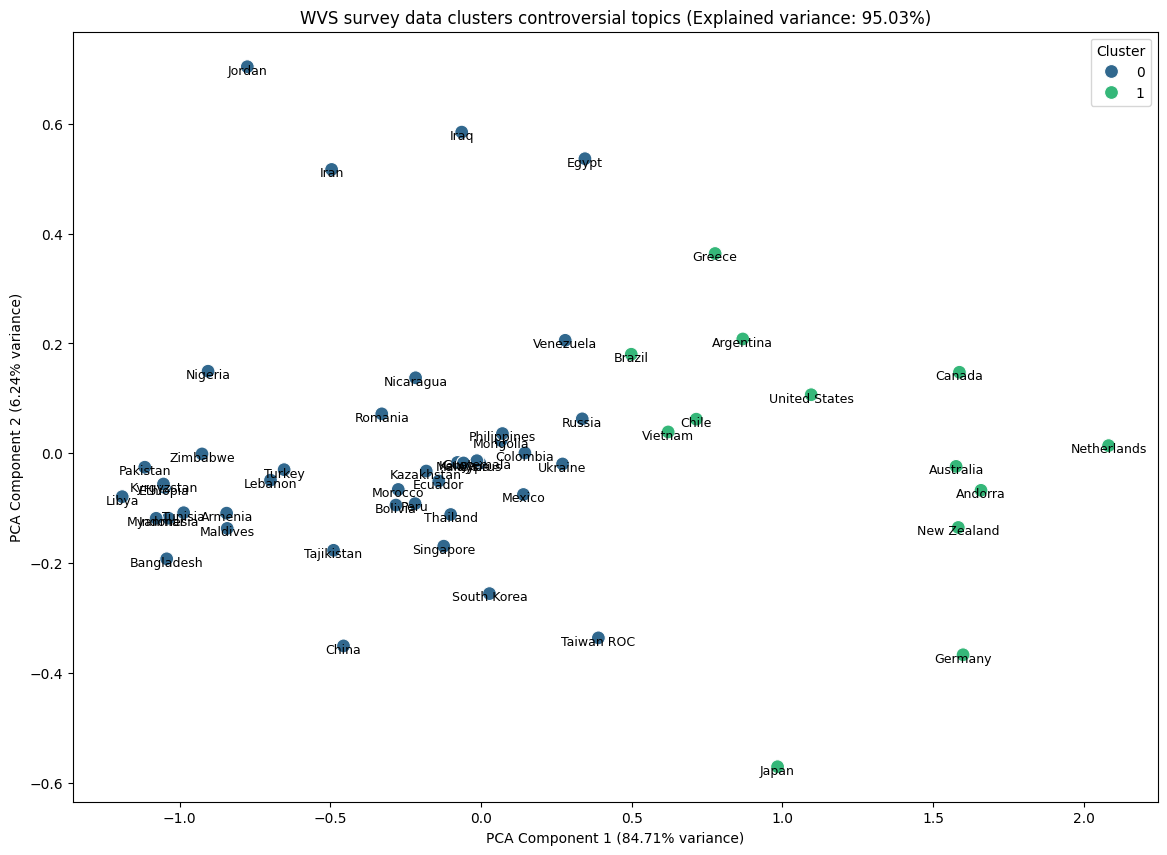

Model: gpt2-medium
Adjusted Rand Index: -0.015
Adjusted Mutual Information: -0.011
Combined Alignment Score: -0.013


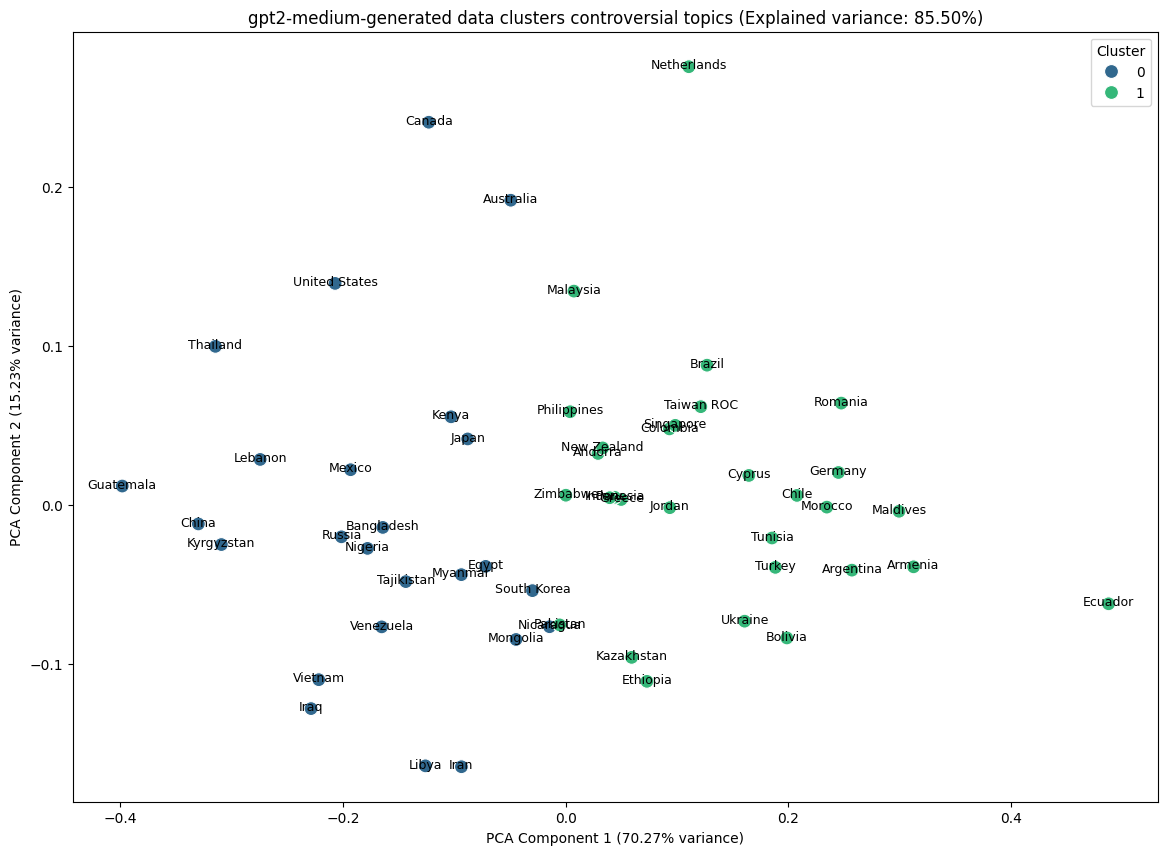

Model: gpt2-large
Adjusted Rand Index: -0.012
Adjusted Mutual Information: 0.023
Combined Alignment Score: 0.005


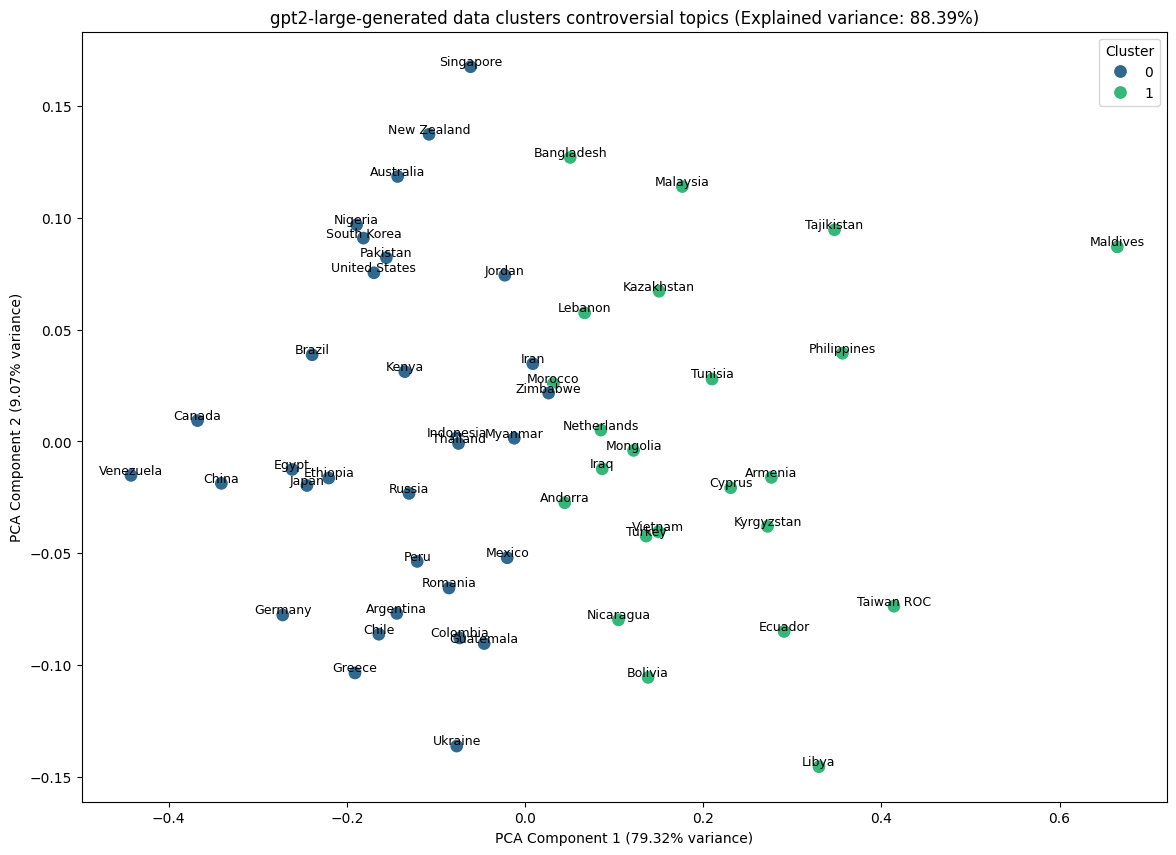

Model: OPT-125
Adjusted Rand Index: -0.021
Adjusted Mutual Information: 0.017
Combined Alignment Score: -0.002


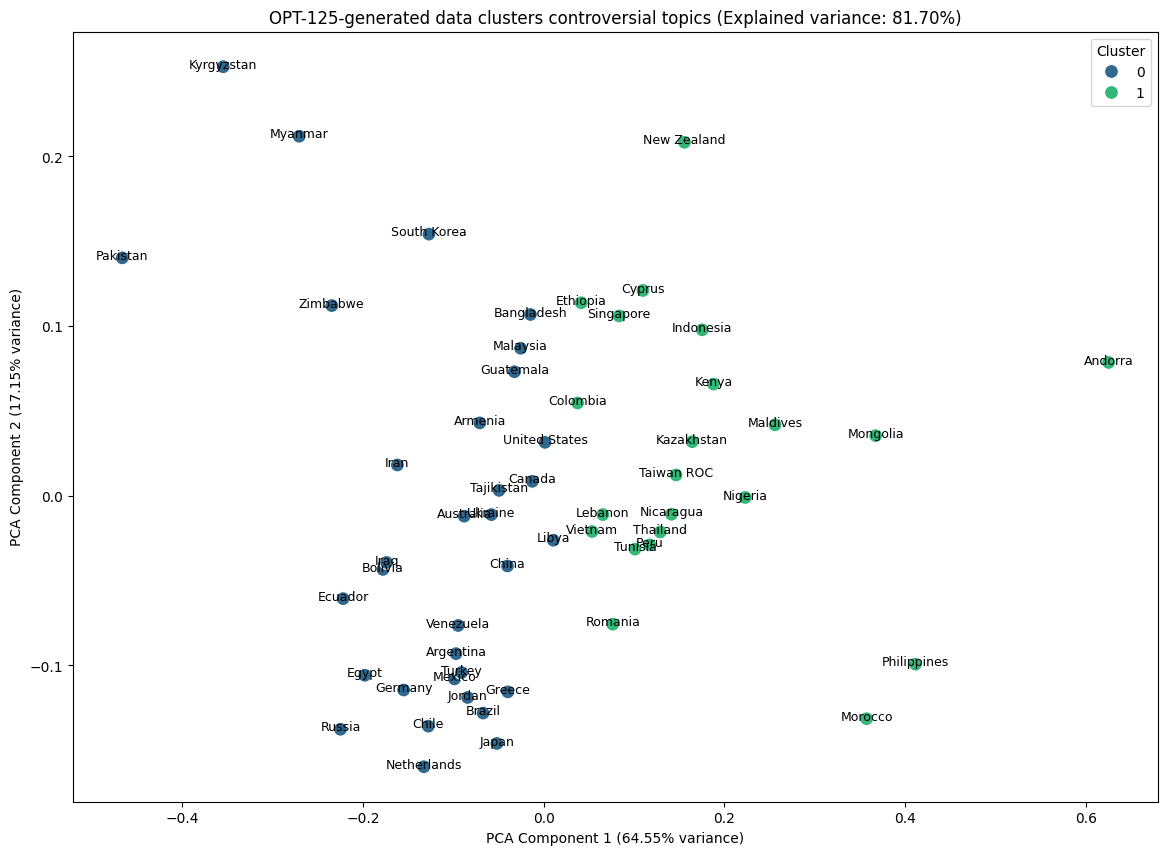

Model: QWEN
Adjusted Rand Index: -0.014
Adjusted Mutual Information: -0.018
Combined Alignment Score: -0.016


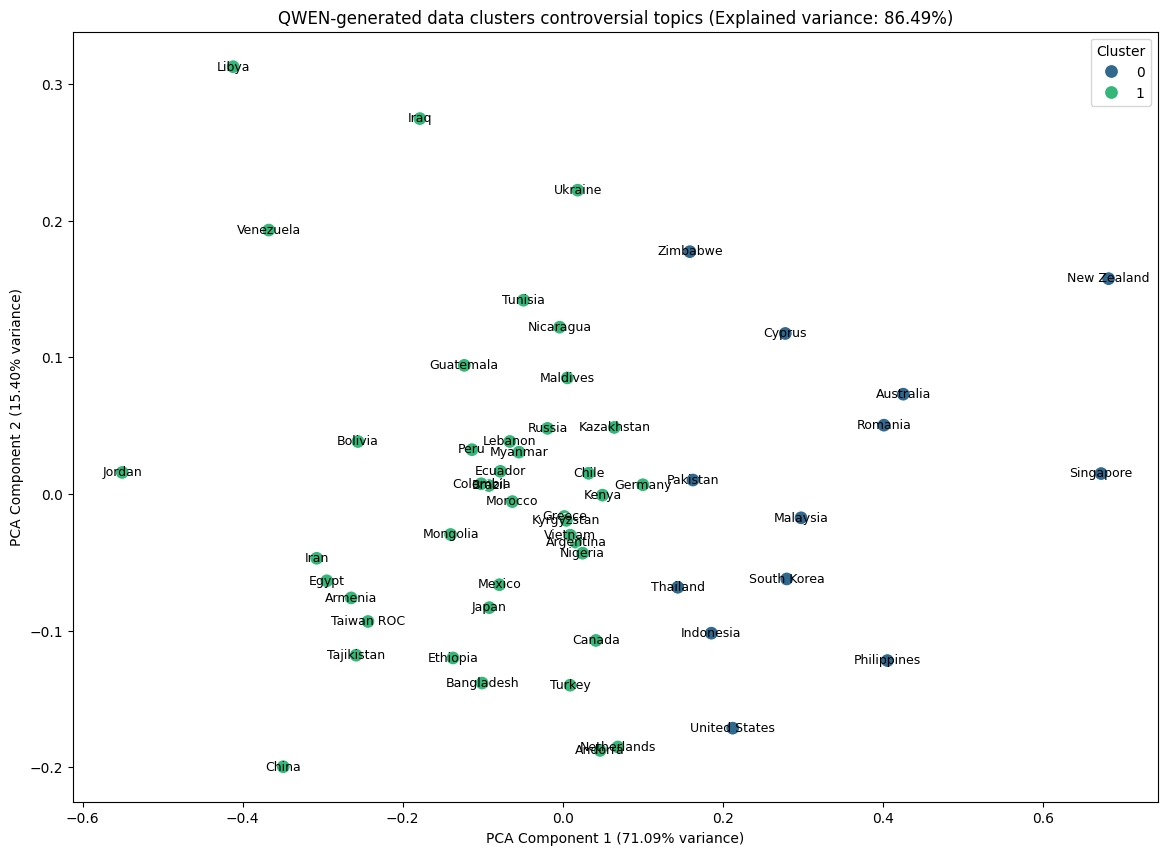

Model: BLOOM
Adjusted Rand Index: -0.015
Adjusted Mutual Information: -0.011
Combined Alignment Score: -0.013


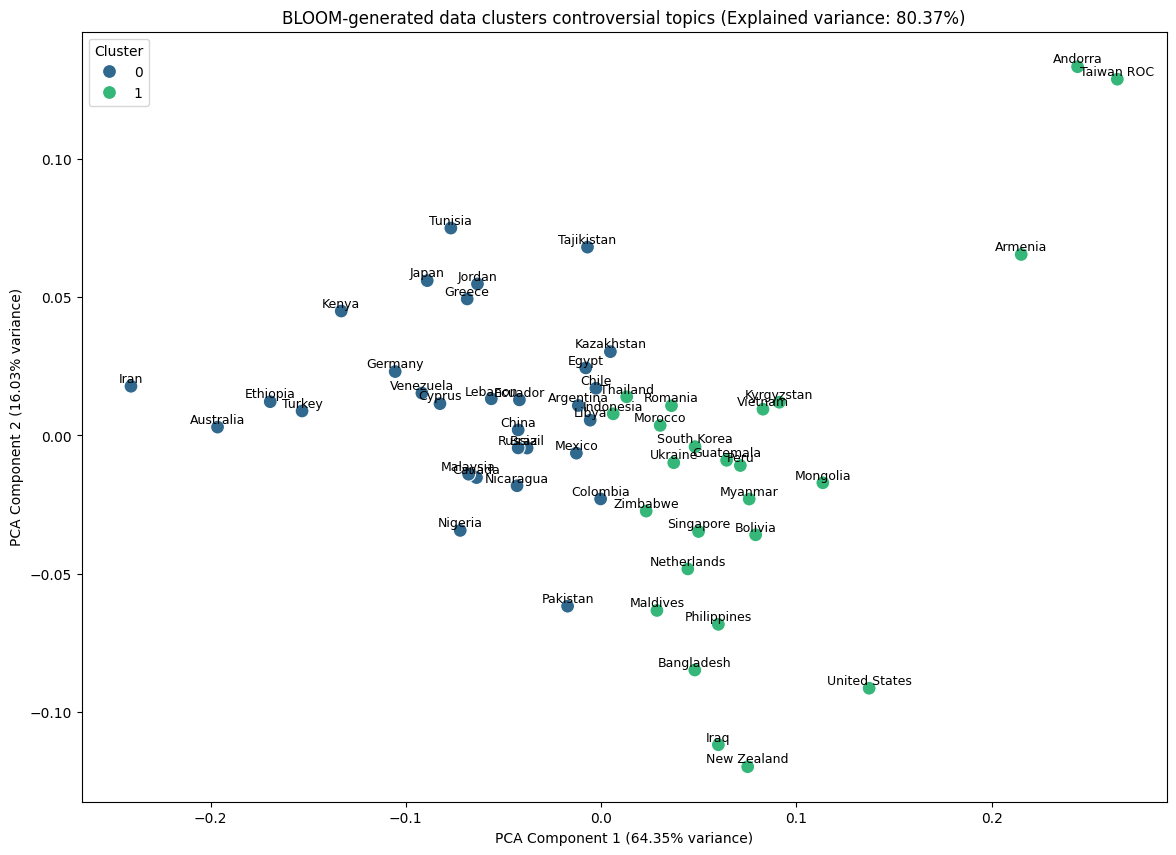

In [488]:
controversial_topics = list(most_controversial_WVS['topic'])

cluster_and_compare(WVS_preprocessed_df[controversial_topics], 'WVS', models, "controversial topics")

#### Result 3: most agreed on topics

Optimal k for survey data: 2
Optimal number of PCA components: 2


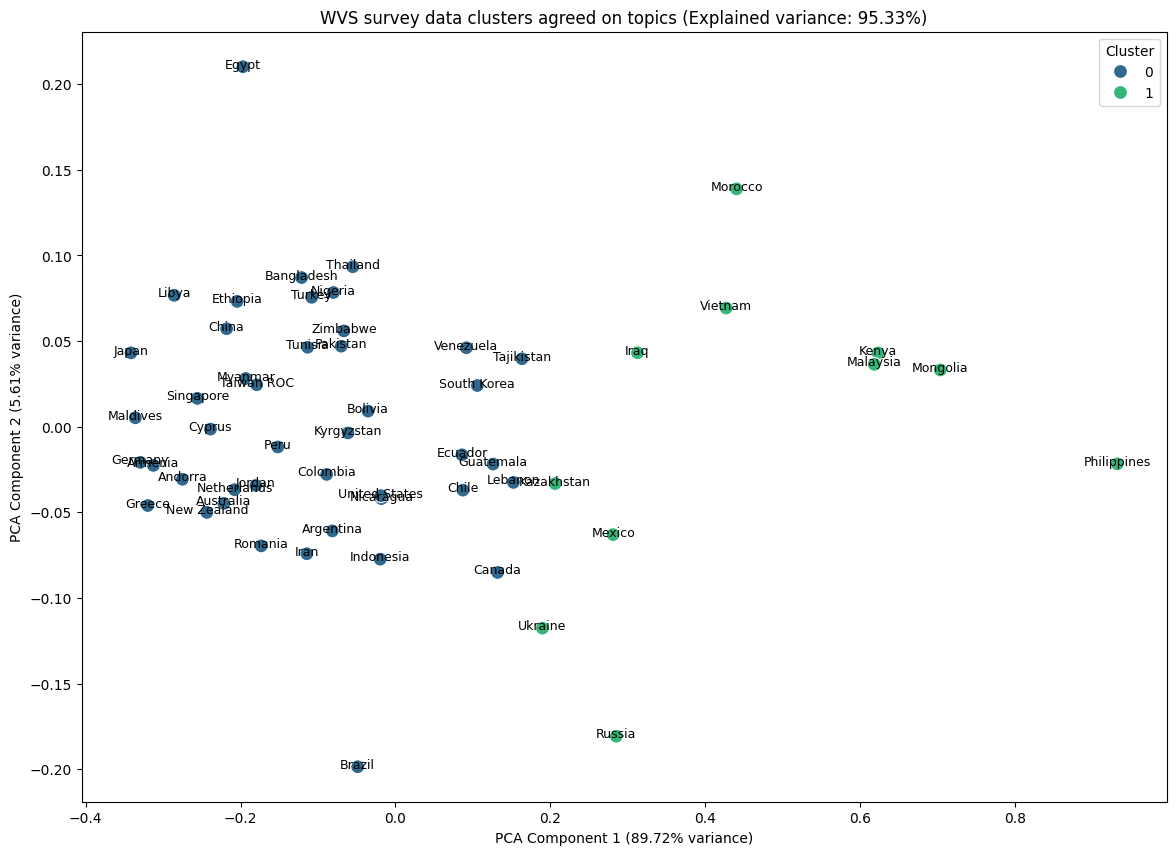

Model: gpt2-medium
Adjusted Rand Index: 0.079
Adjusted Mutual Information: 0.01
Combined Alignment Score: 0.044


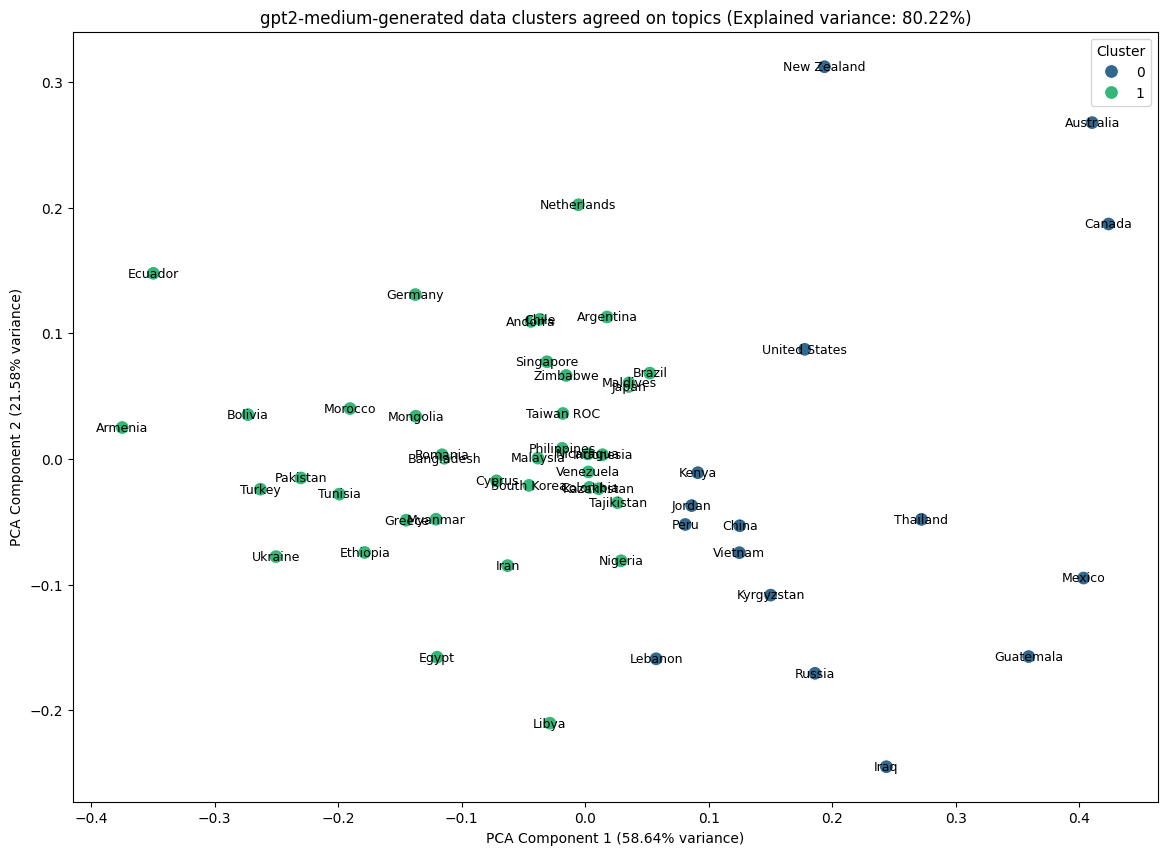

Model: gpt2-large
Adjusted Rand Index: -0.019
Adjusted Mutual Information: -0.014
Combined Alignment Score: -0.016


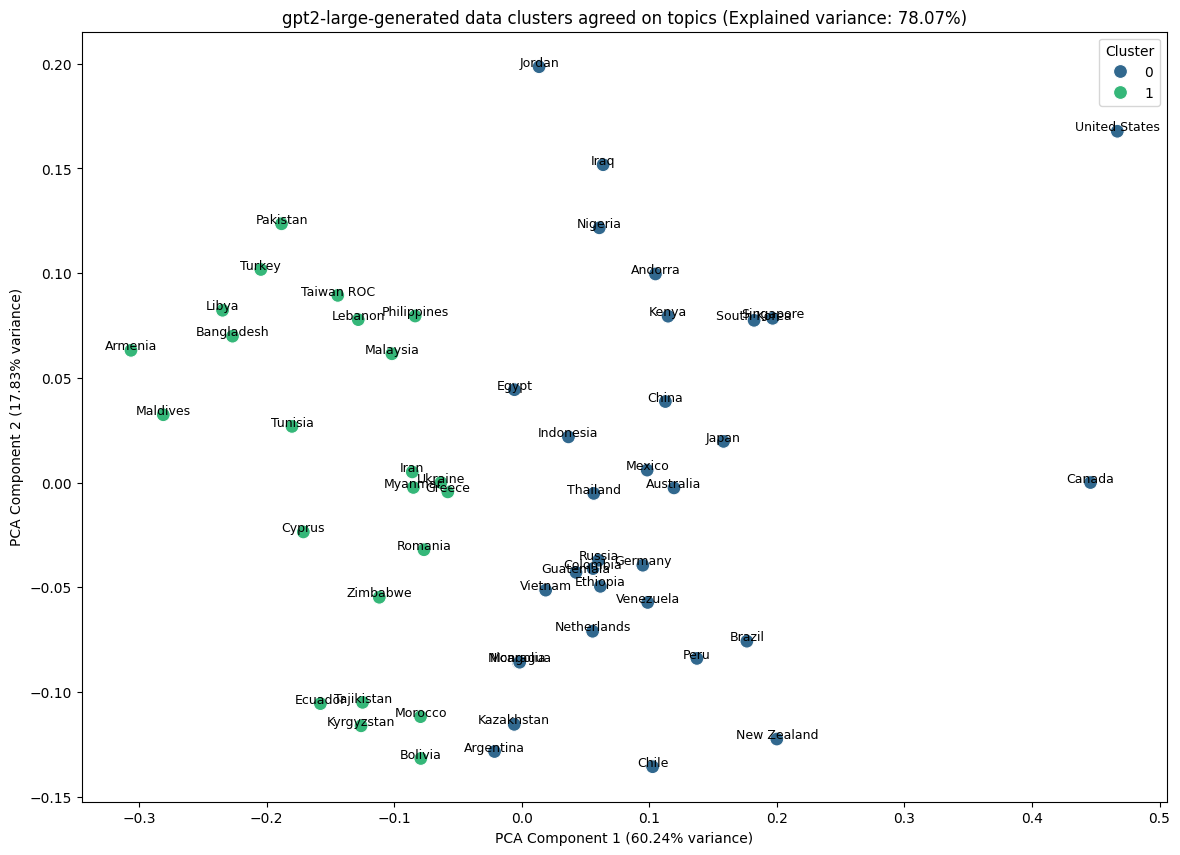

Model: OPT-125
Adjusted Rand Index: 0.12
Adjusted Mutual Information: 0.038
Combined Alignment Score: 0.079


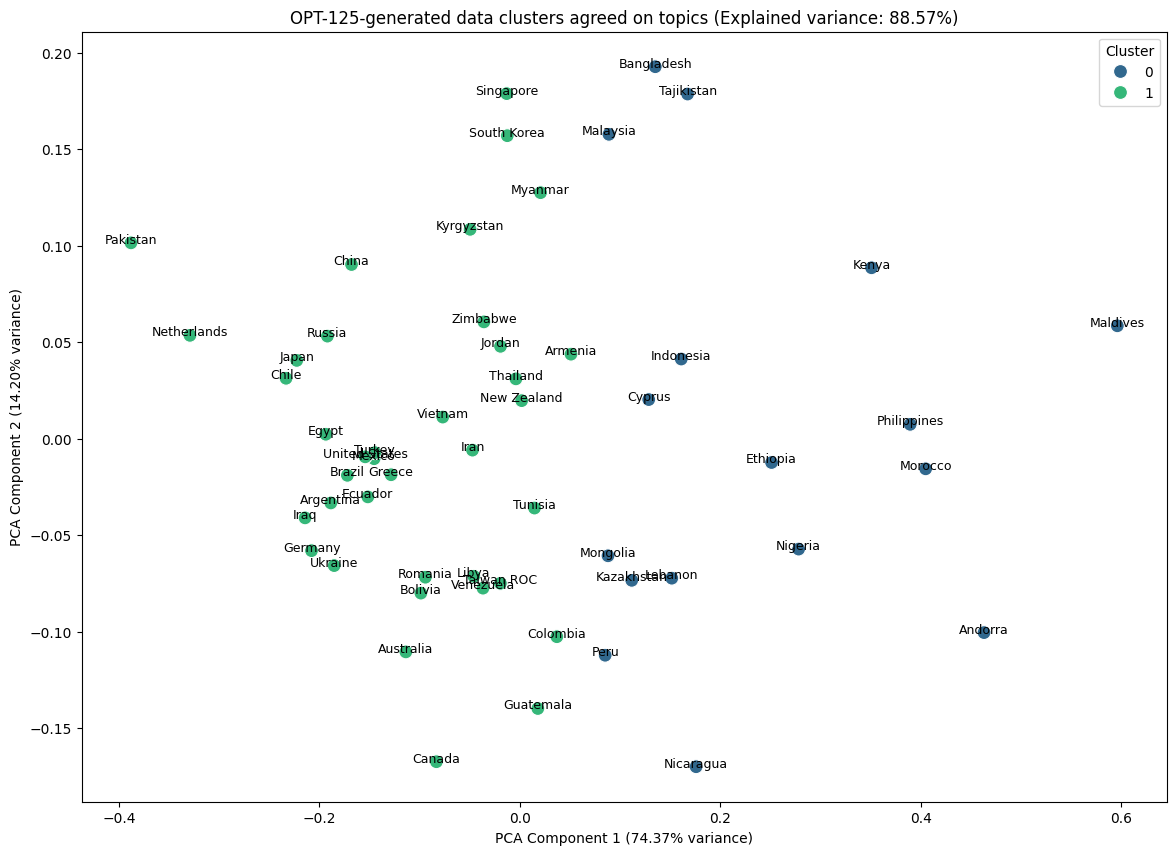

Model: QWEN
Adjusted Rand Index: -0.005
Adjusted Mutual Information: -0.017
Combined Alignment Score: -0.011


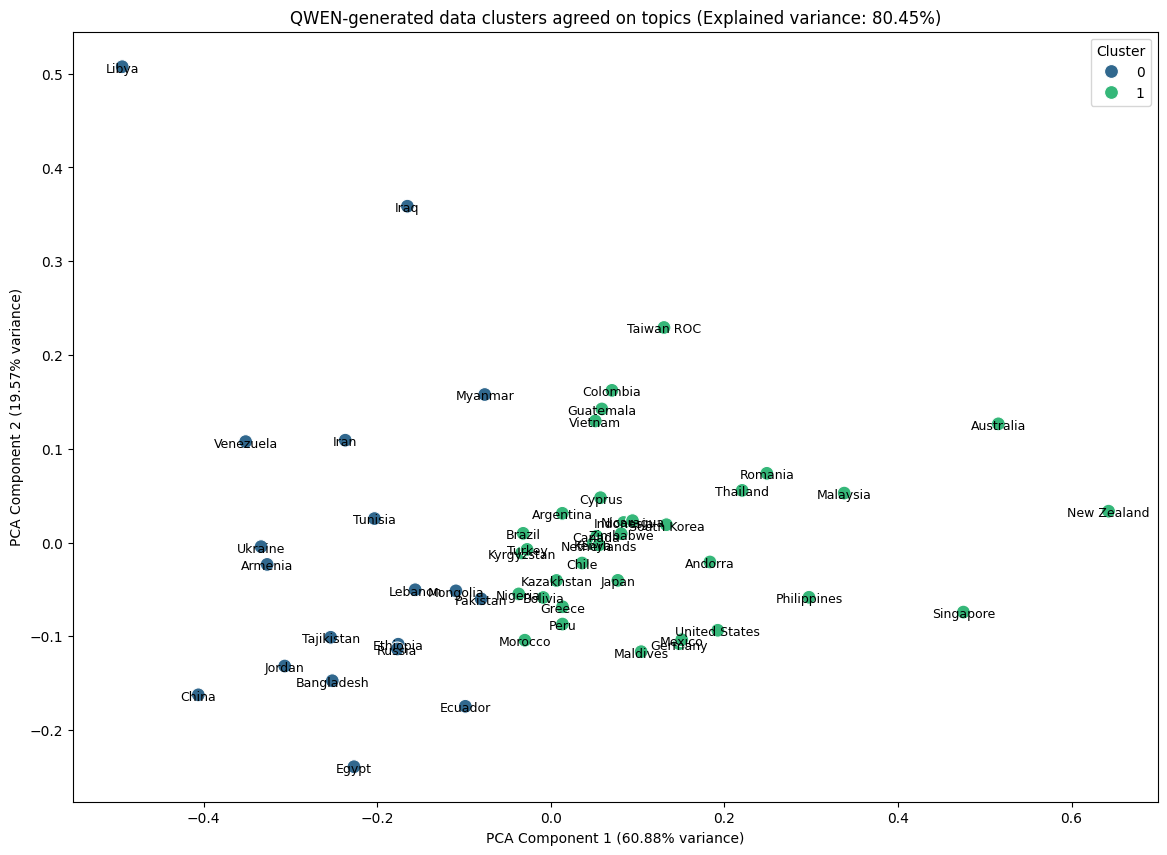

Model: BLOOM
Adjusted Rand Index: -0.03
Adjusted Mutual Information: -0.012
Combined Alignment Score: -0.021


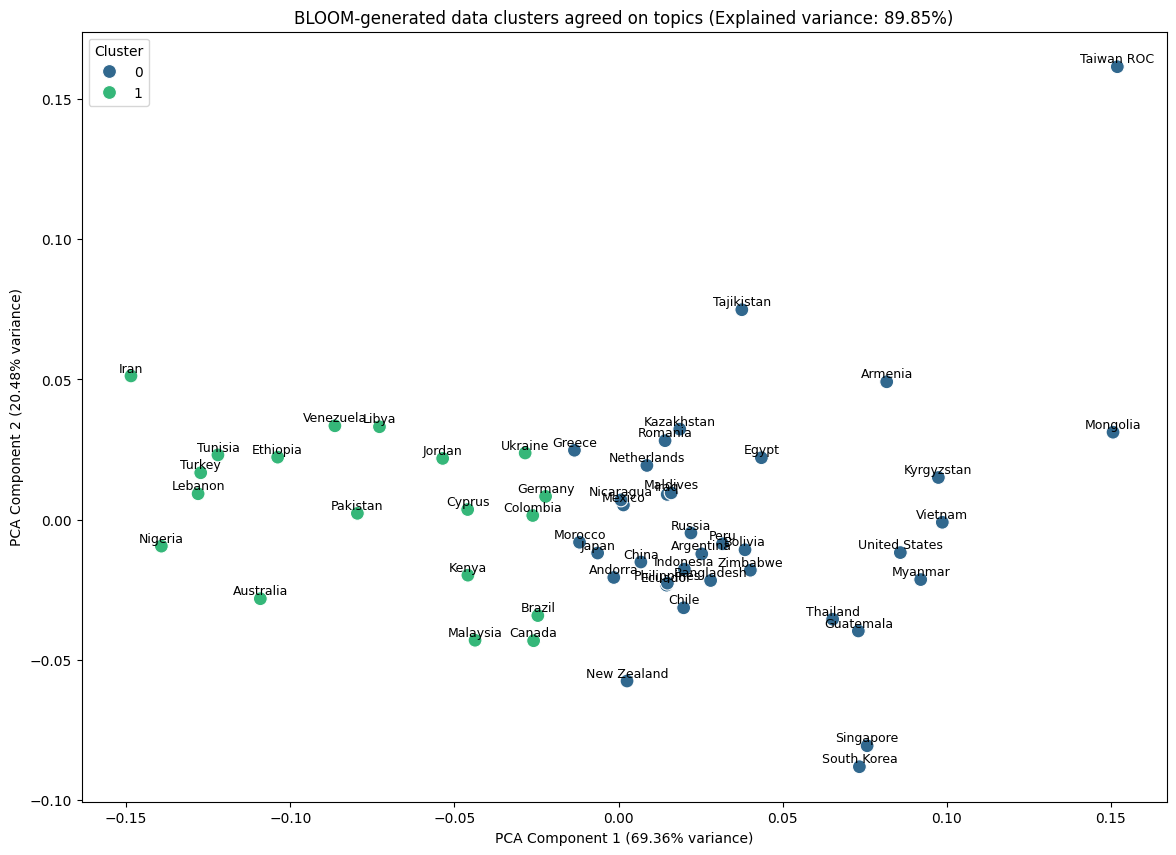

In [489]:
agreed_topics = list(most_agreed_on_WVS['topic'])

cluster_and_compare(WVS_preprocessed_df[agreed_topics], 'WVS', models, 'agreed on topics')

### PEW

#### Result 1: all topics together

Optimal k for survey data: 2
Optimal number of PCA components: 5


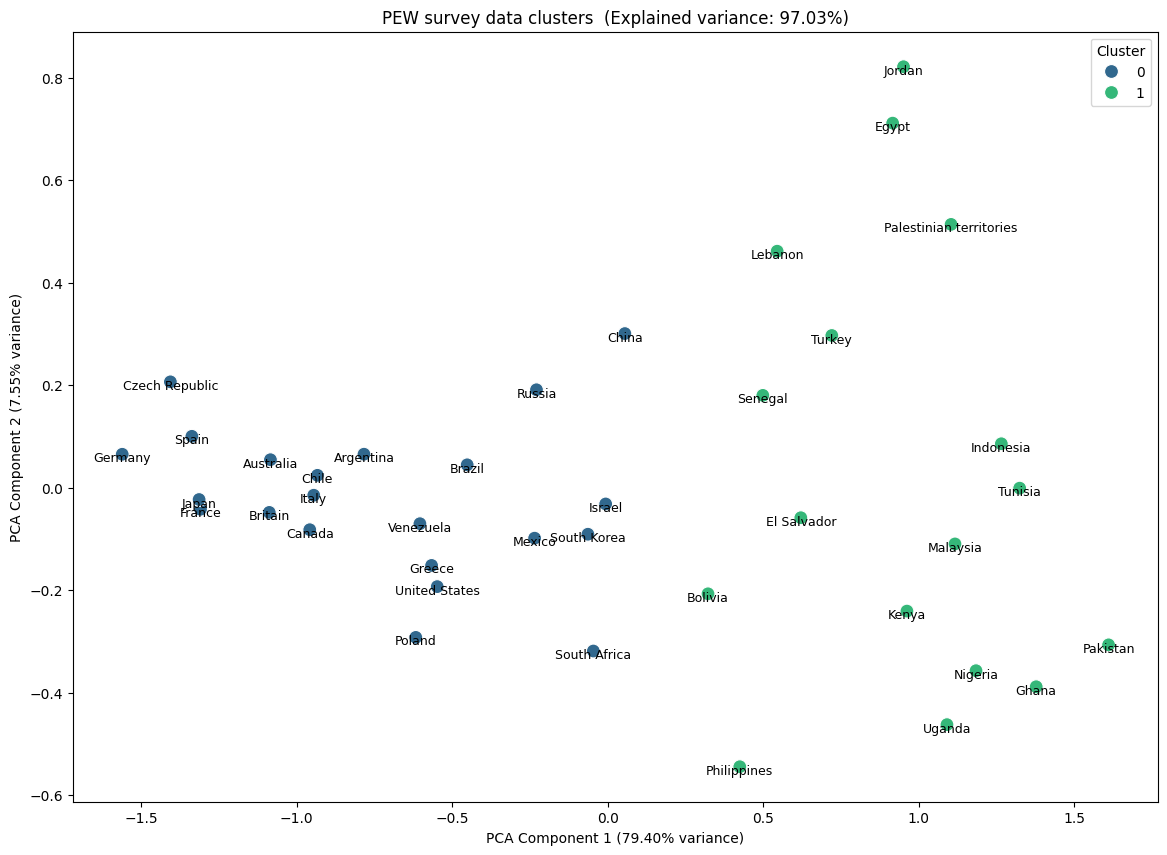

Model: gpt2-medium
Adjusted Rand Index: 0.087
Adjusted Mutual Information: 0.068
Combined Alignment Score: 0.078


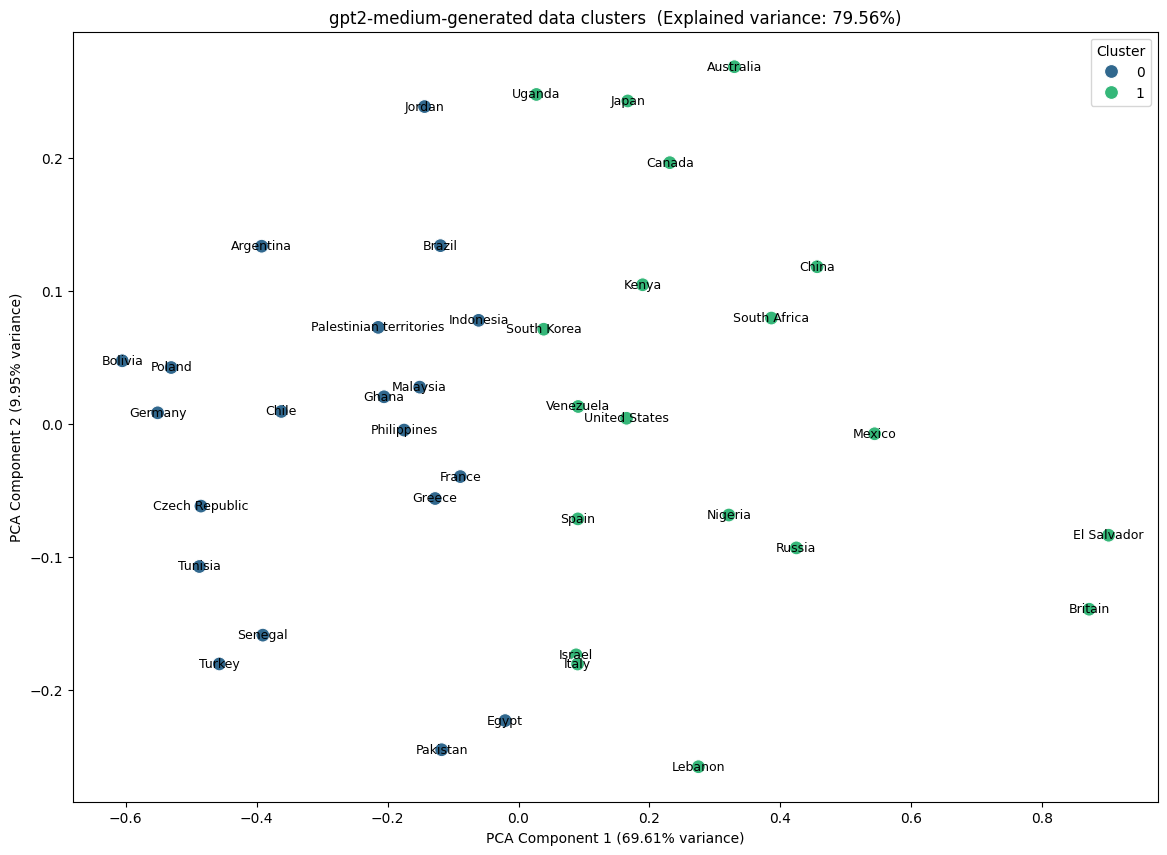

Model: gpt2-large
Adjusted Rand Index: 0.129
Adjusted Mutual Information: 0.123
Combined Alignment Score: 0.126


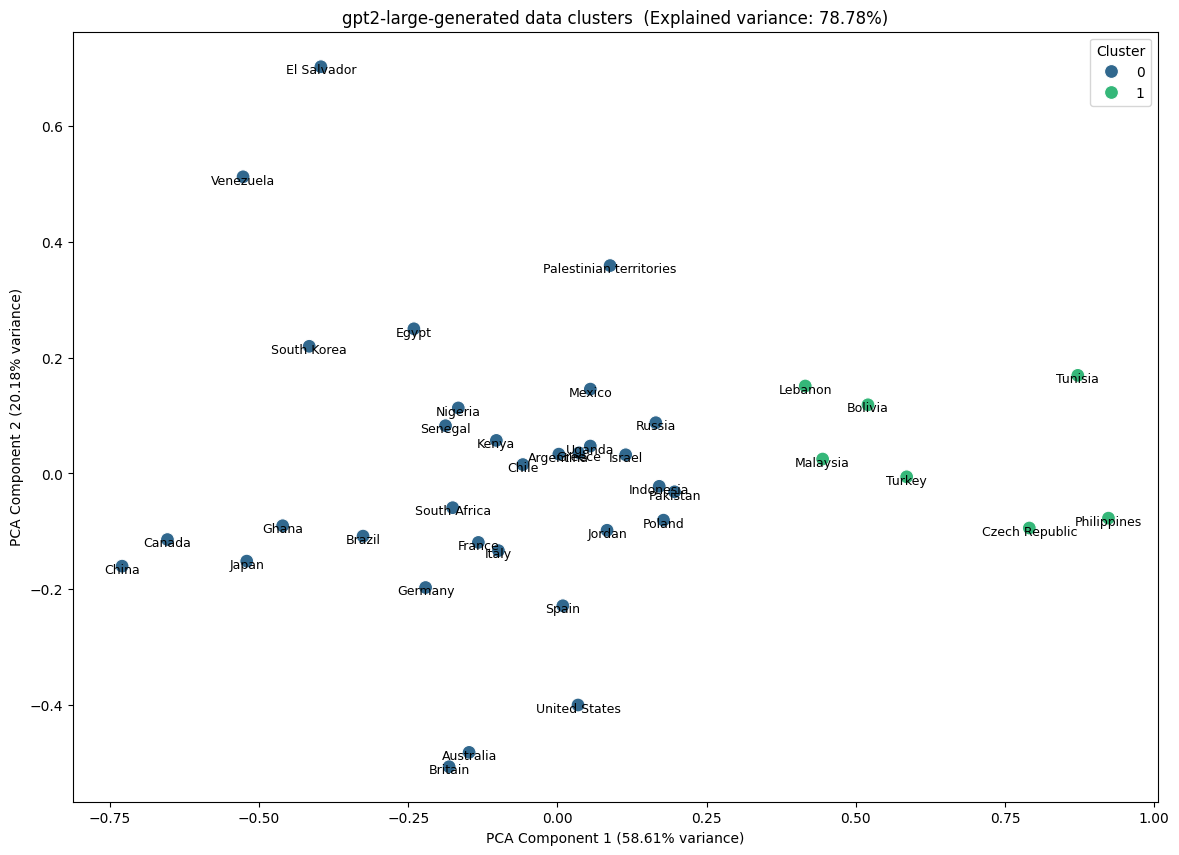

Model: OPT-125
Adjusted Rand Index: 0.129
Adjusted Mutual Information: 0.123
Combined Alignment Score: 0.126


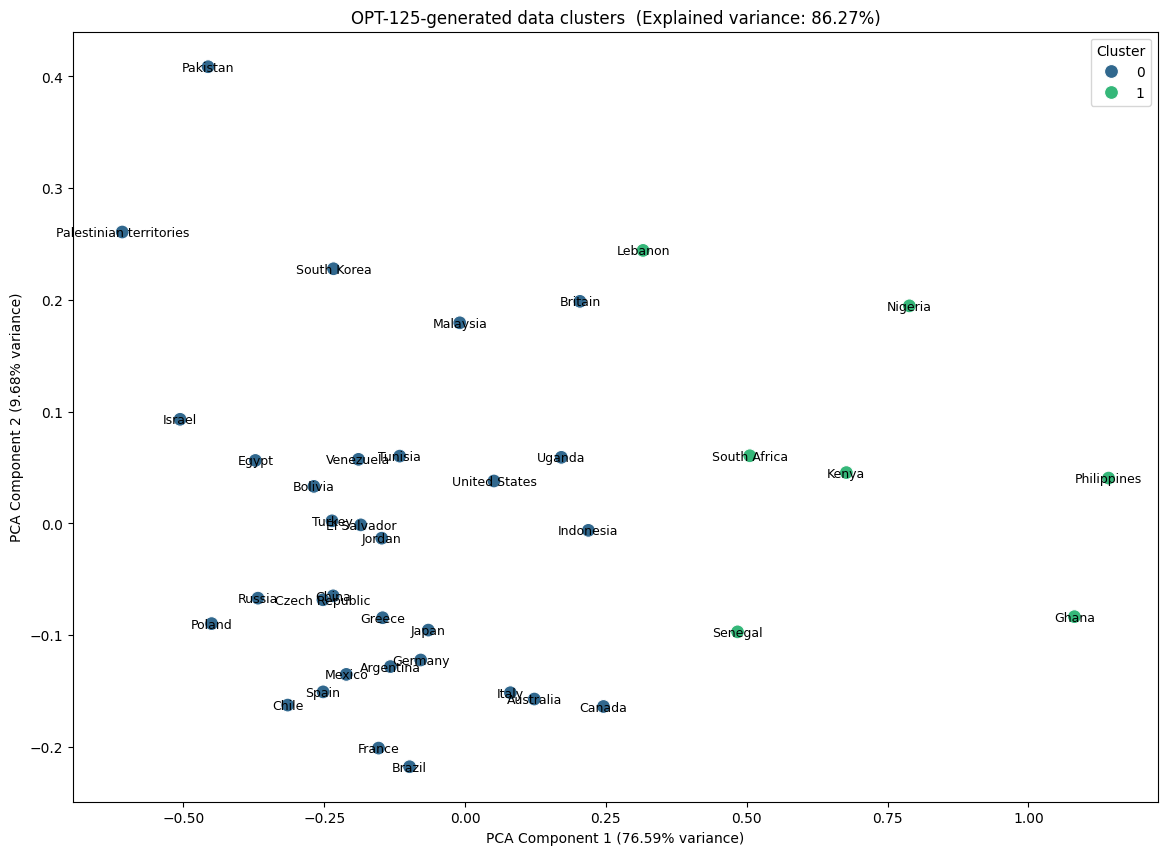

Model: QWEN
Adjusted Rand Index: -0.019
Adjusted Mutual Information: 0.065
Combined Alignment Score: 0.023


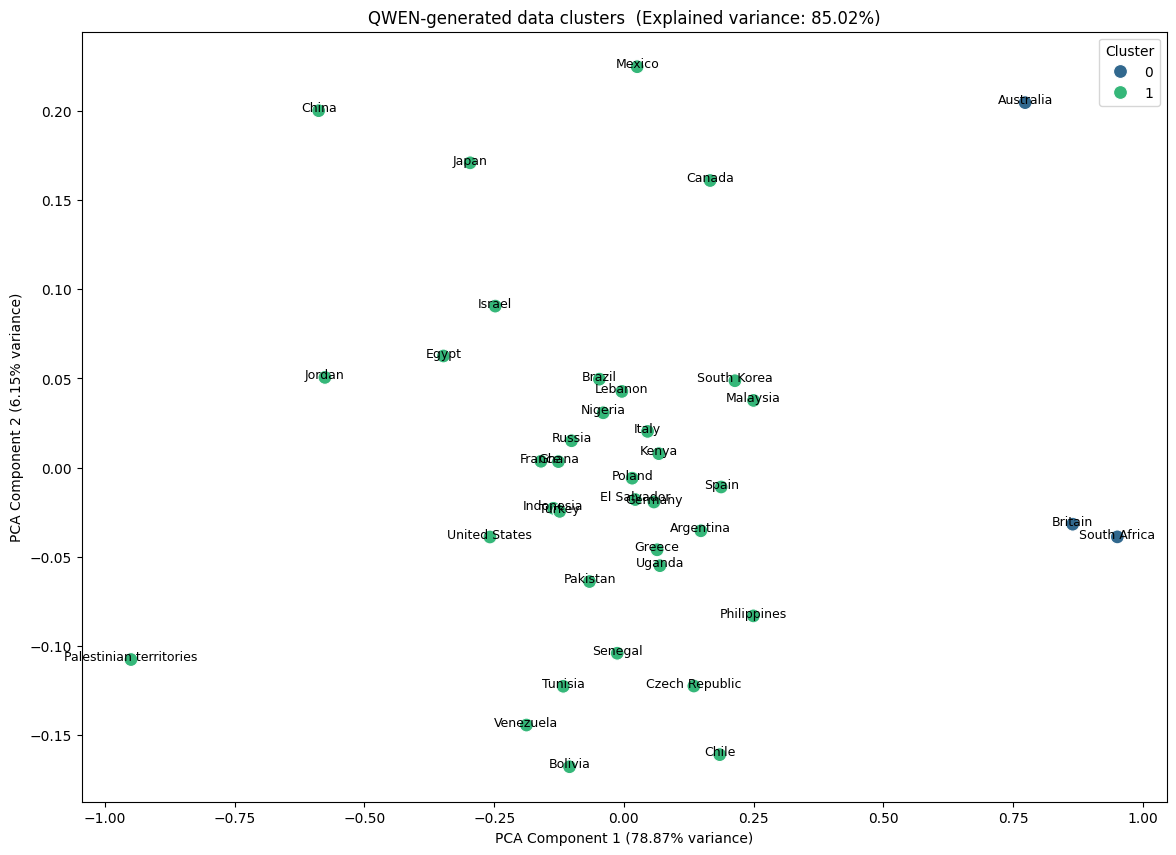

Model: BLOOM
Adjusted Rand Index: 0.008
Adjusted Mutual Information: -0.004
Combined Alignment Score: 0.002


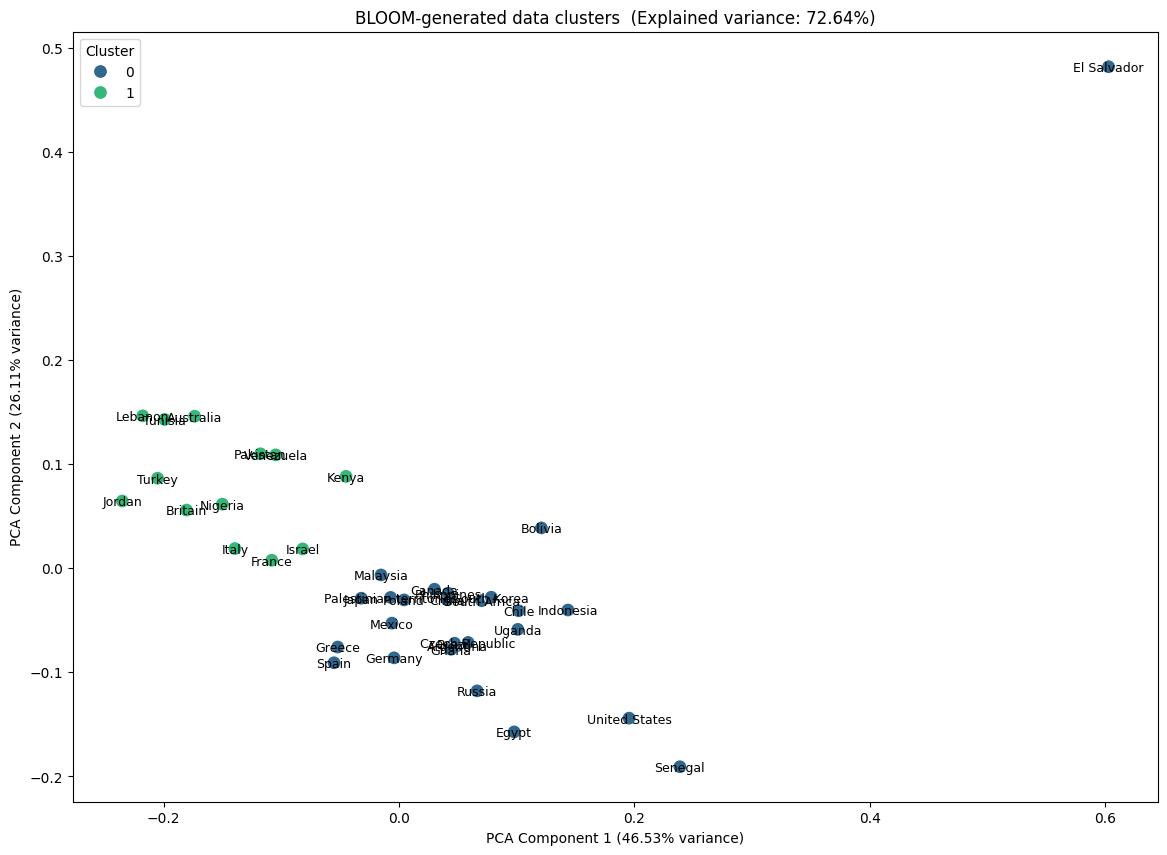

In [490]:
cluster_and_compare(PEW_preprocessed_df, 'PEW', models)

#### Result 2: most controversial topics

Optimal k for survey data: 2
Optimal number of PCA components: 2


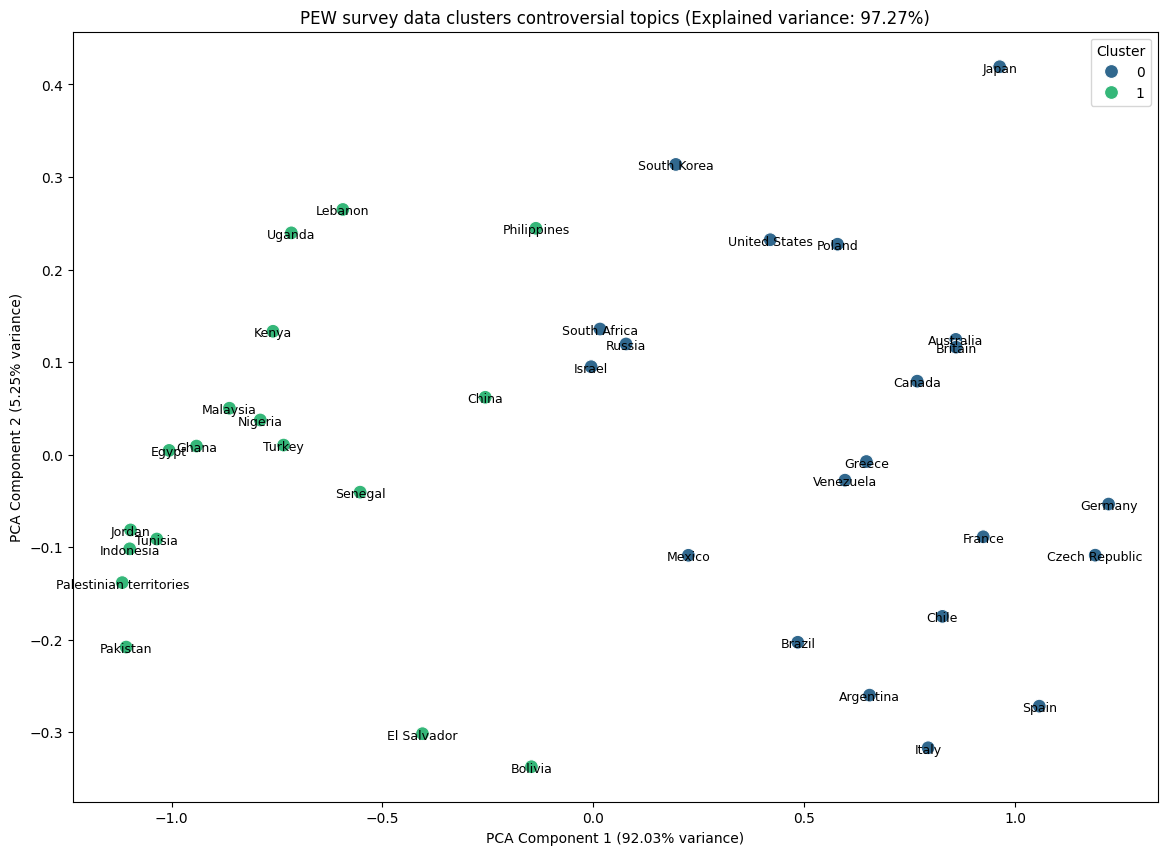

Model: gpt2-medium
Adjusted Rand Index: -0.026
Adjusted Mutual Information: -0.019
Combined Alignment Score: -0.022


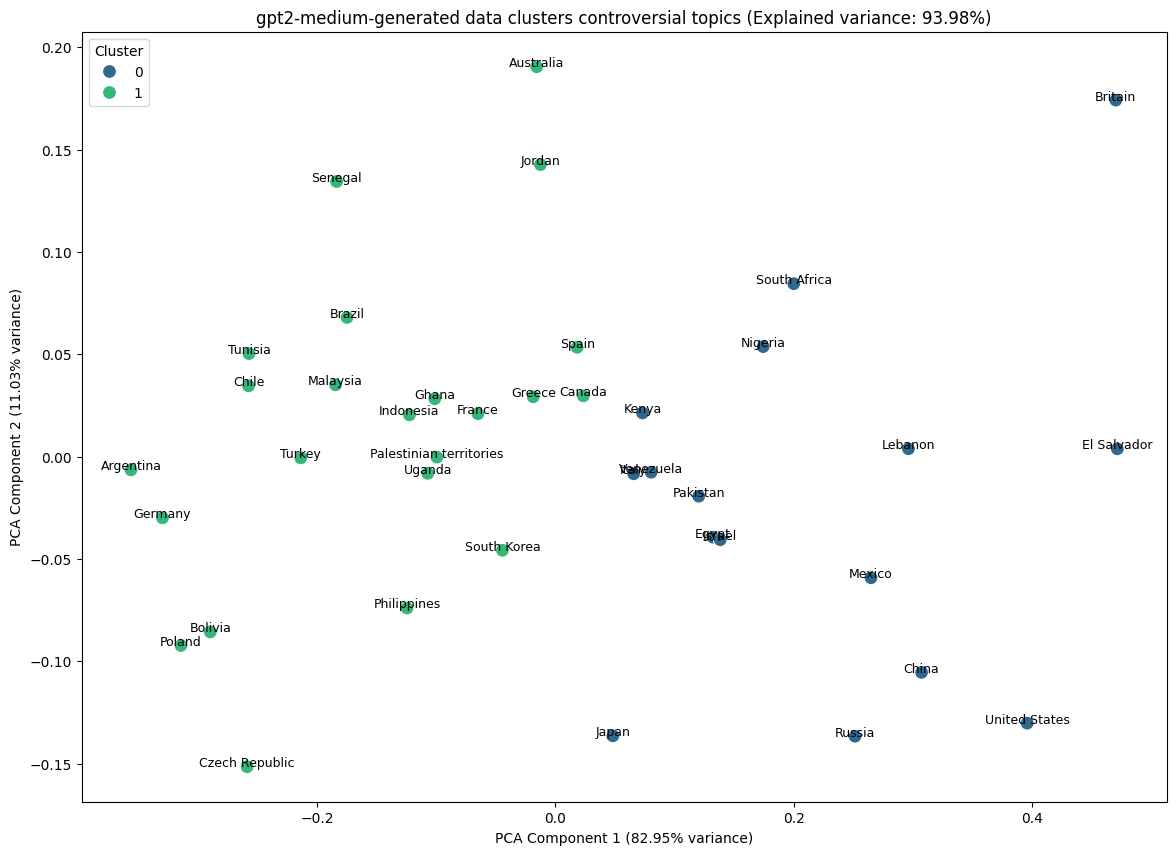

Model: gpt2-large
Adjusted Rand Index: 0.093
Adjusted Mutual Information: 0.081
Combined Alignment Score: 0.087


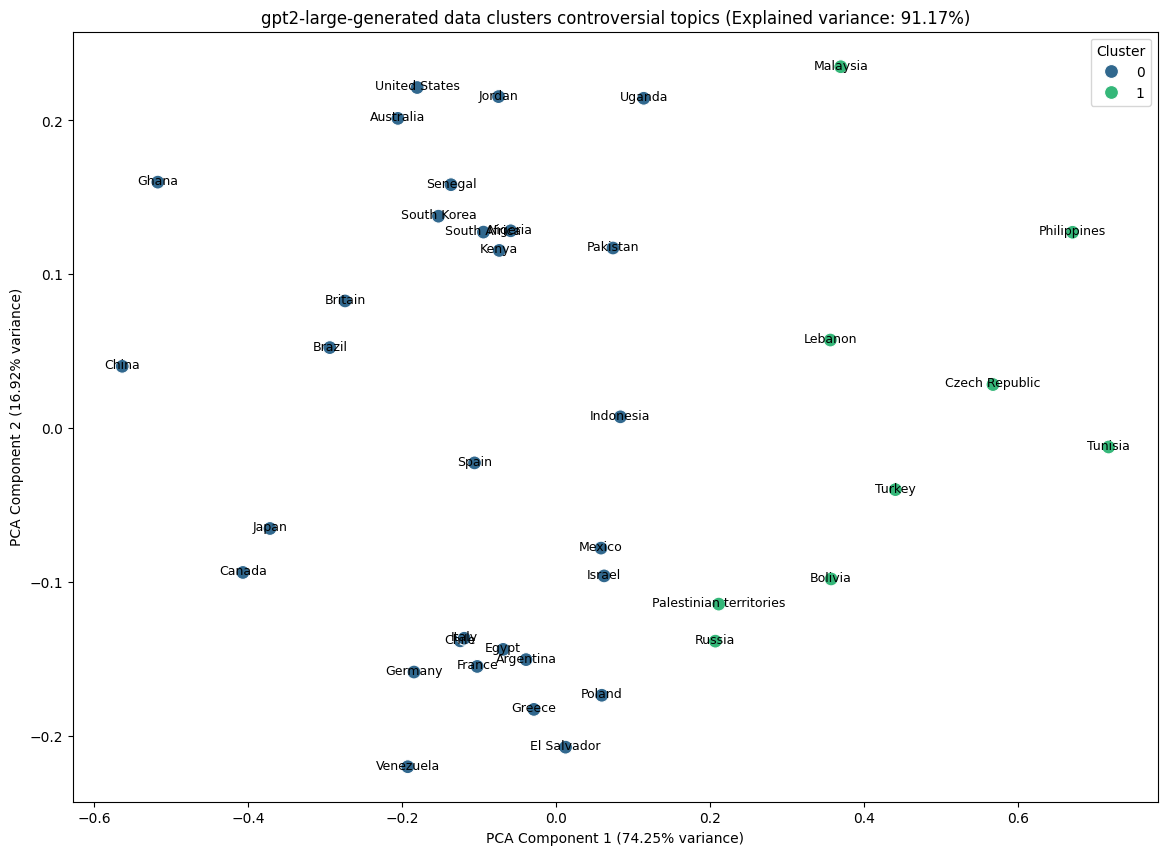

Model: OPT-125
Adjusted Rand Index: 0.131
Adjusted Mutual Information: 0.14
Combined Alignment Score: 0.136


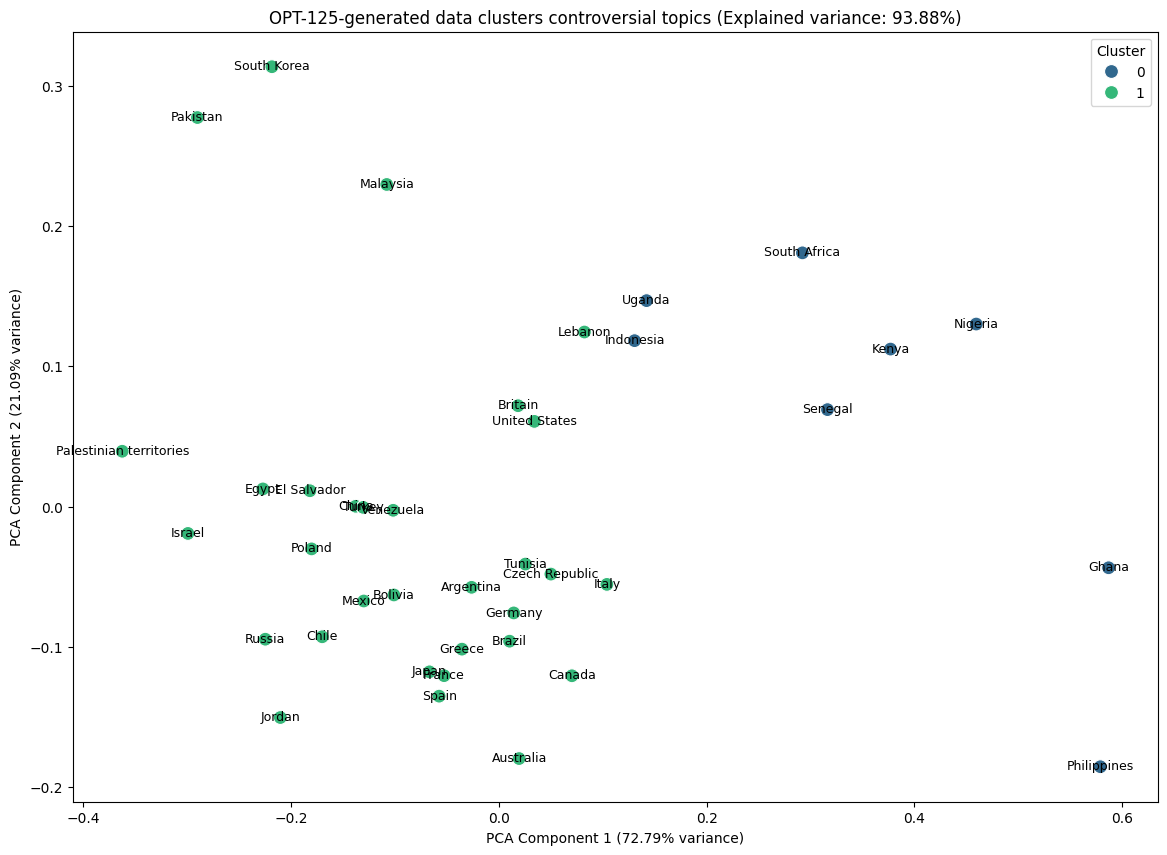

Model: QWEN
Adjusted Rand Index: -0.006
Adjusted Mutual Information: 0.073
Combined Alignment Score: 0.033


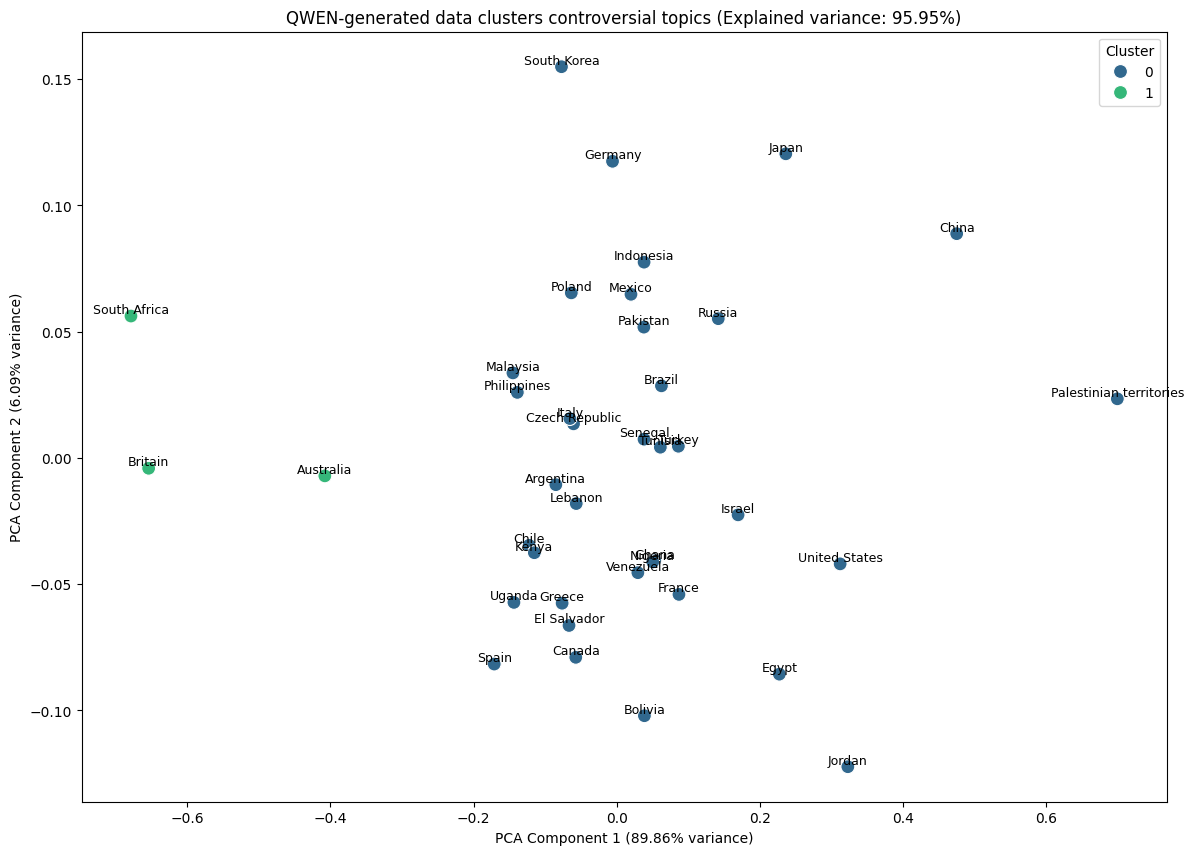

Model: BLOOM
Adjusted Rand Index: 0.009
Adjusted Mutual Information: 0.006
Combined Alignment Score: 0.007


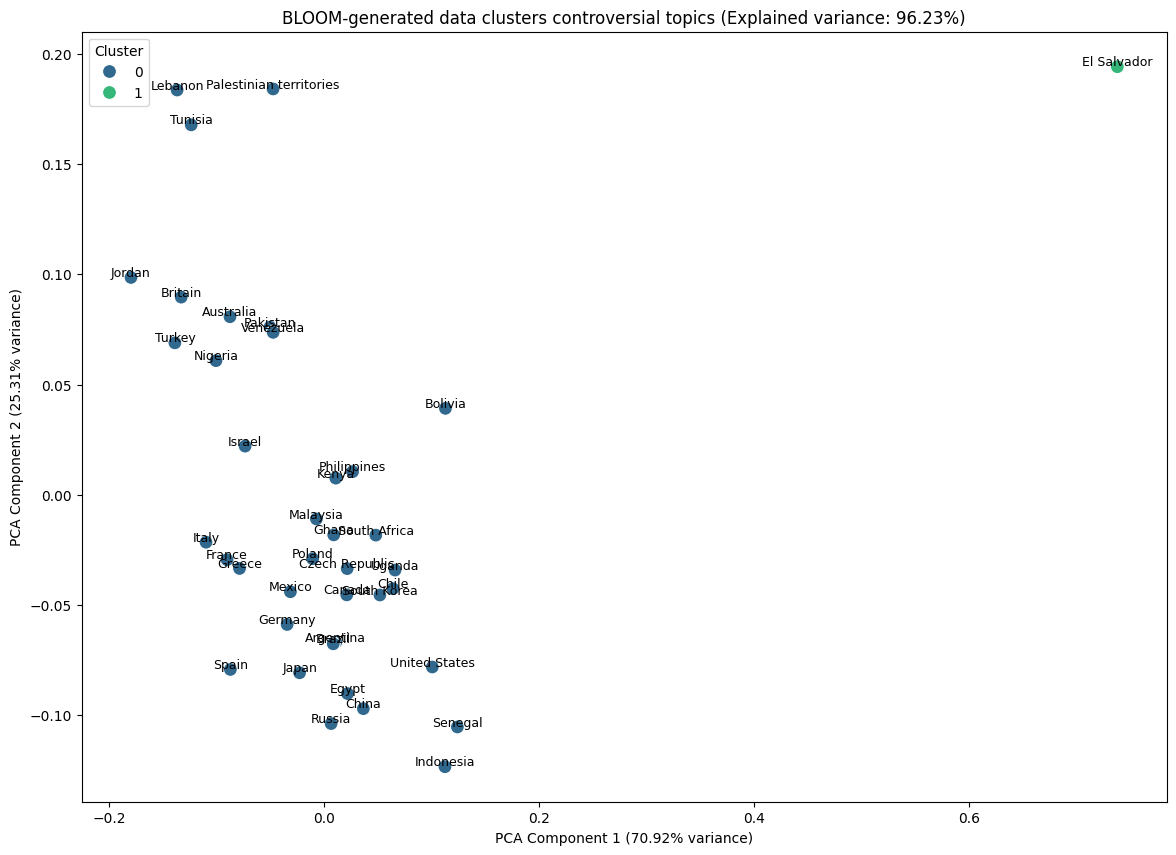

In [491]:
controversial_topics = list(most_controversial_PEW['topic'])

cluster_and_compare(PEW_preprocessed_df[controversial_topics], 'PEW', models, "controversial topics")

#### Result 3: most agreed on topics

Optimal k for survey data: 2
Optimal number of PCA components: 2


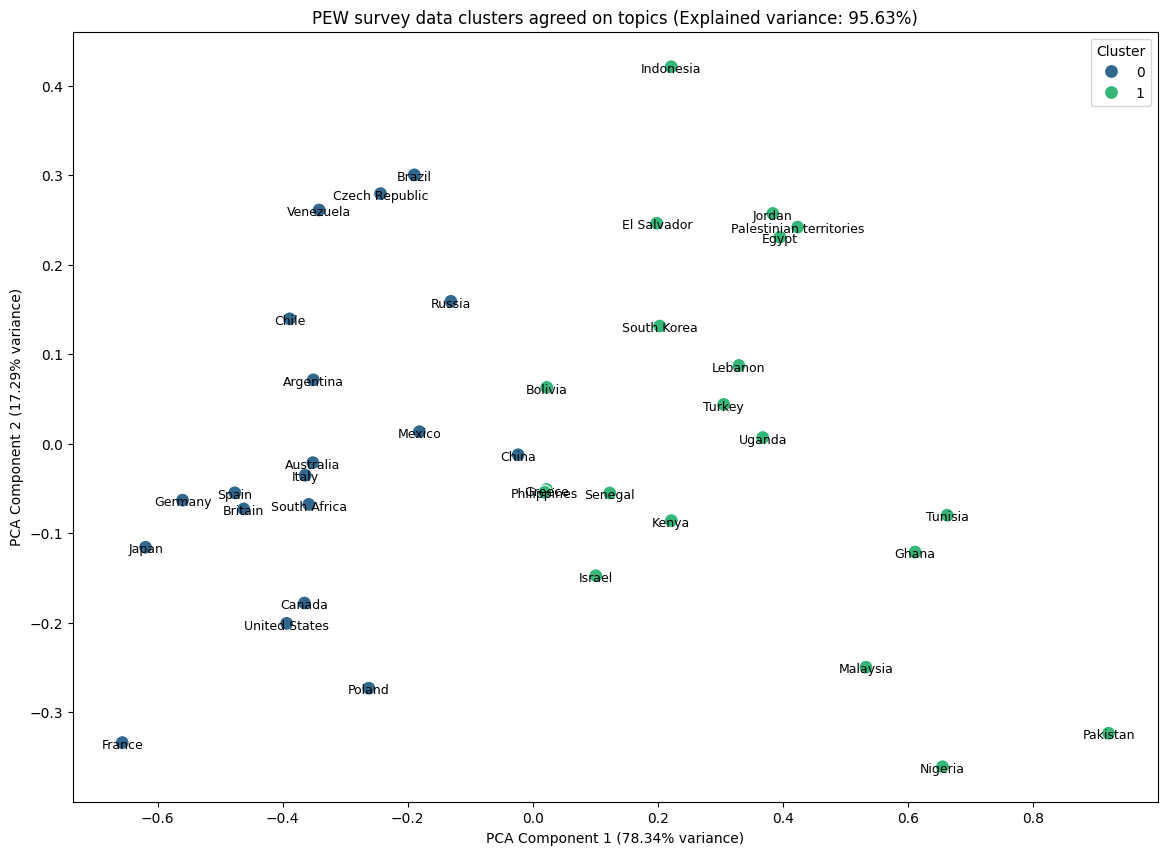

Model: gpt2-medium
Adjusted Rand Index: 0.057
Adjusted Mutual Information: 0.045
Combined Alignment Score: 0.051


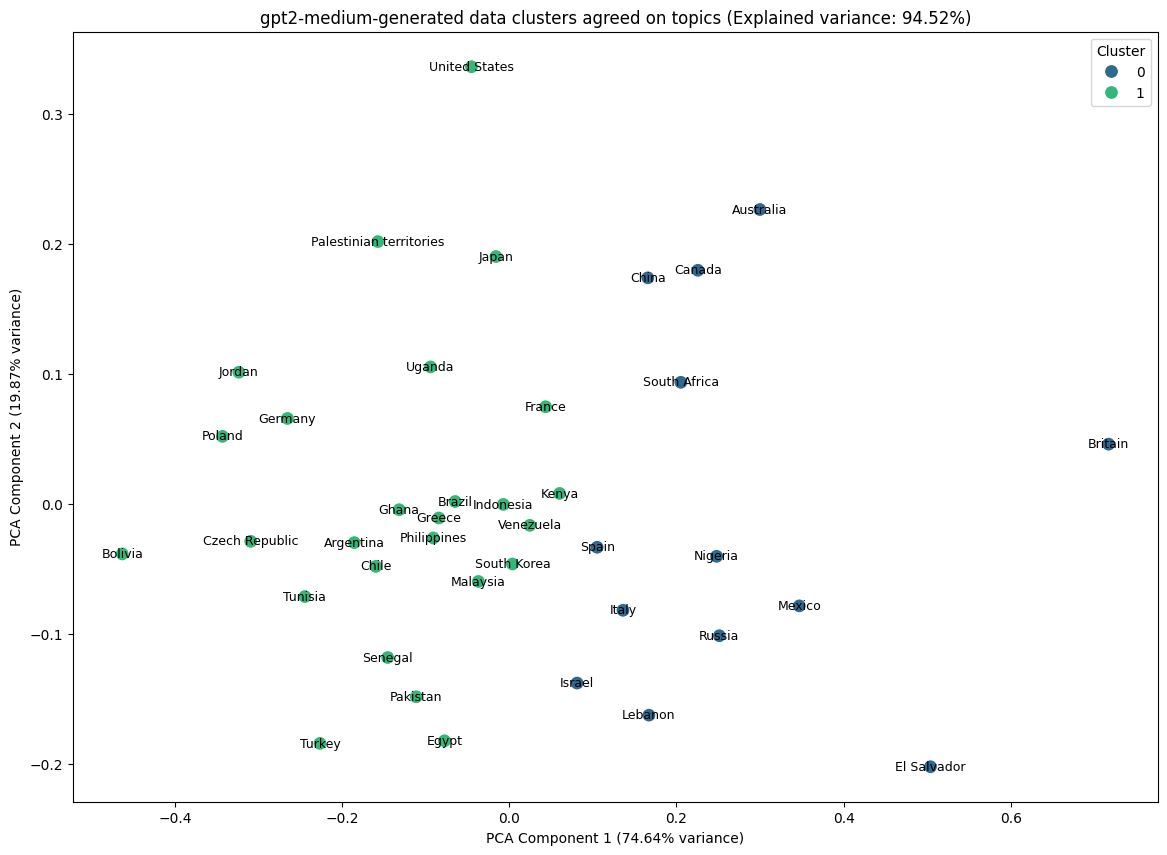

Model: gpt2-large
Adjusted Rand Index: 0.028
Adjusted Mutual Information: 0.02
Combined Alignment Score: 0.024


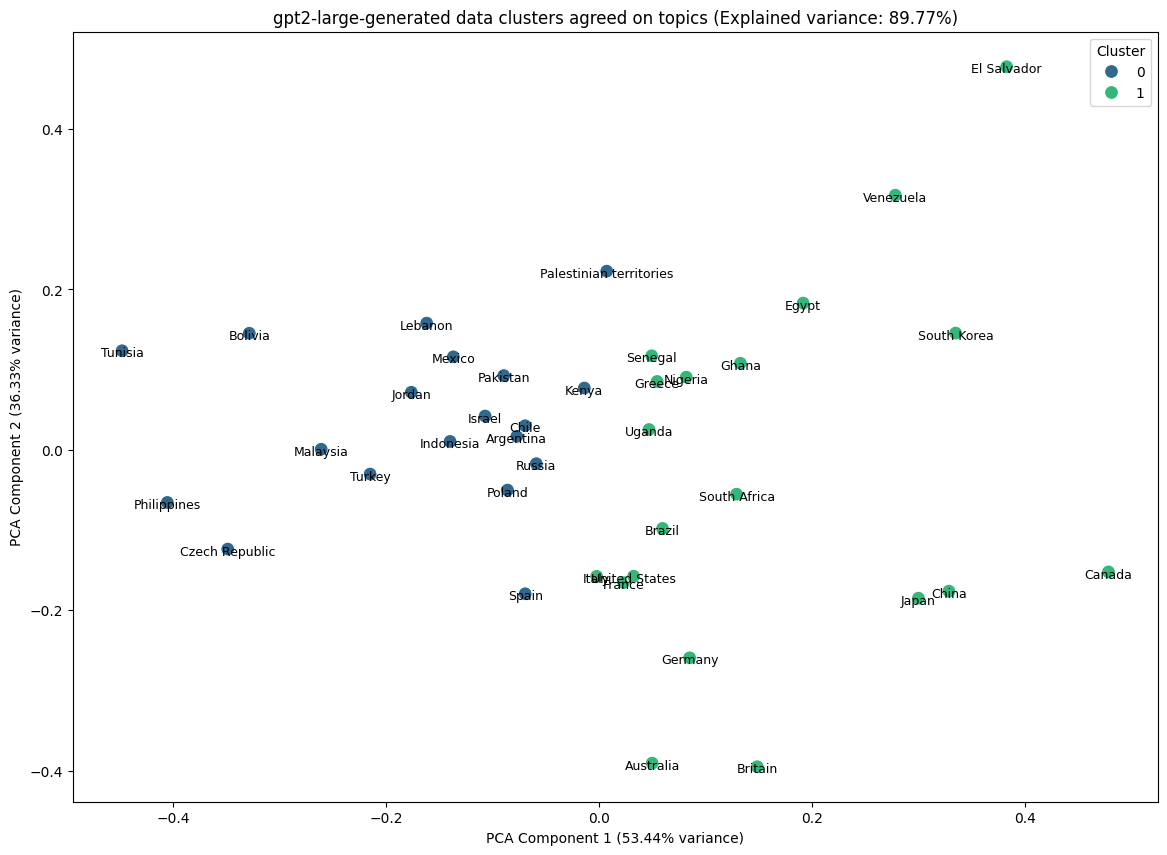

Model: OPT-125
Adjusted Rand Index: 0.035
Adjusted Mutual Information: 0.051
Combined Alignment Score: 0.043


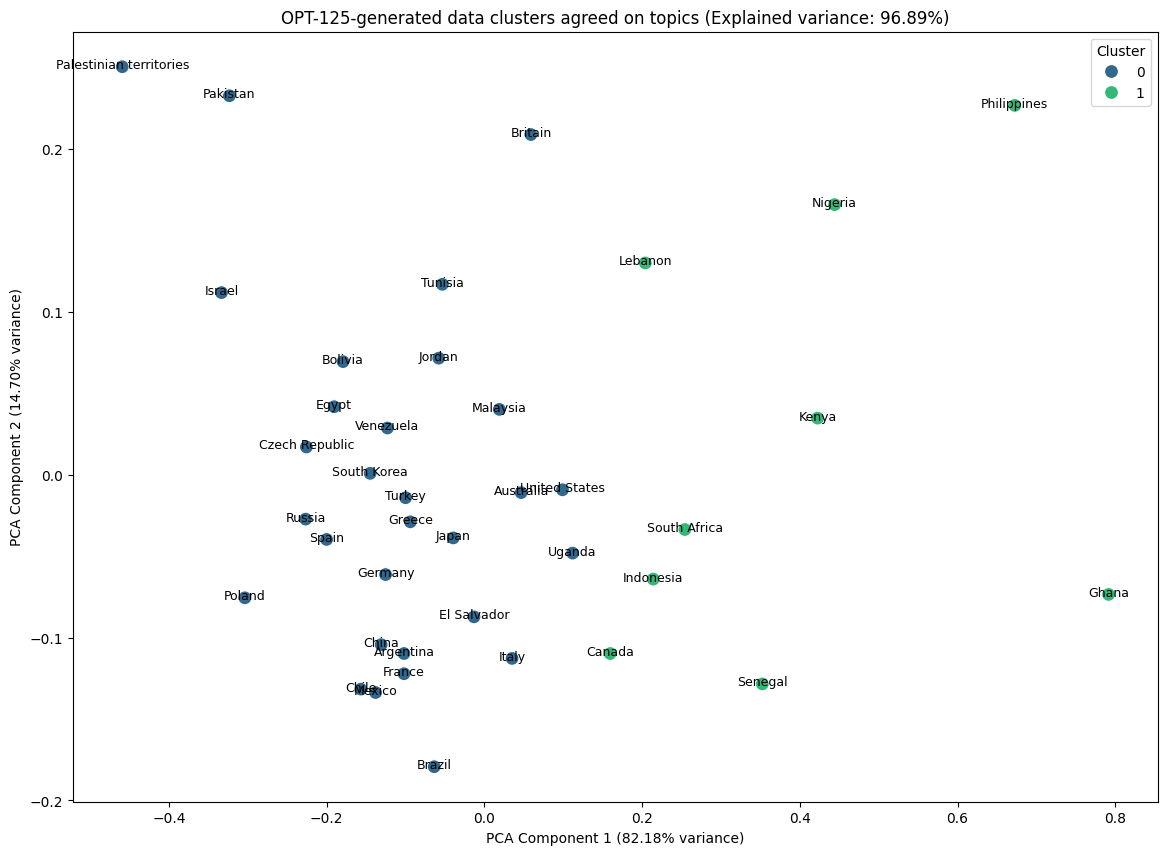

Model: QWEN
Adjusted Rand Index: -0.02
Adjusted Mutual Information: -0.016
Combined Alignment Score: -0.018


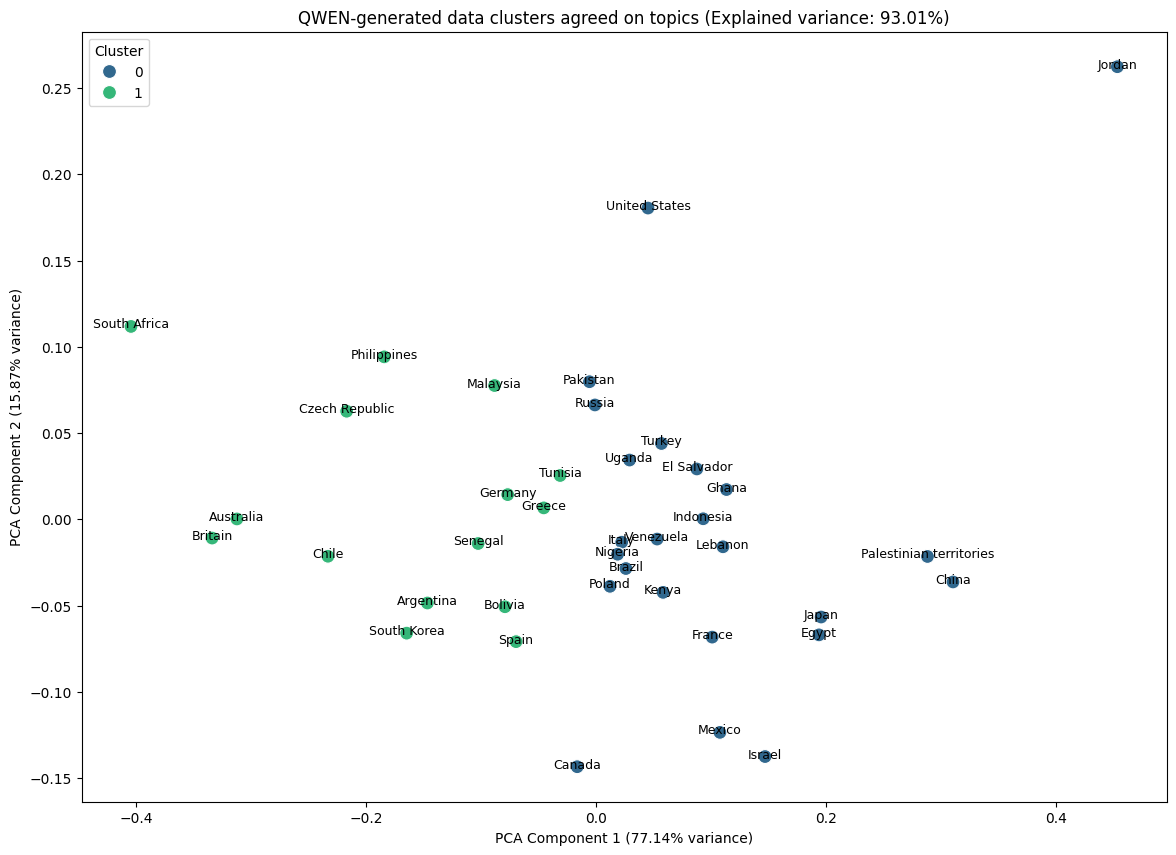

Model: BLOOM
Adjusted Rand Index: 0.006
Adjusted Mutual Information: 0.004
Combined Alignment Score: 0.005


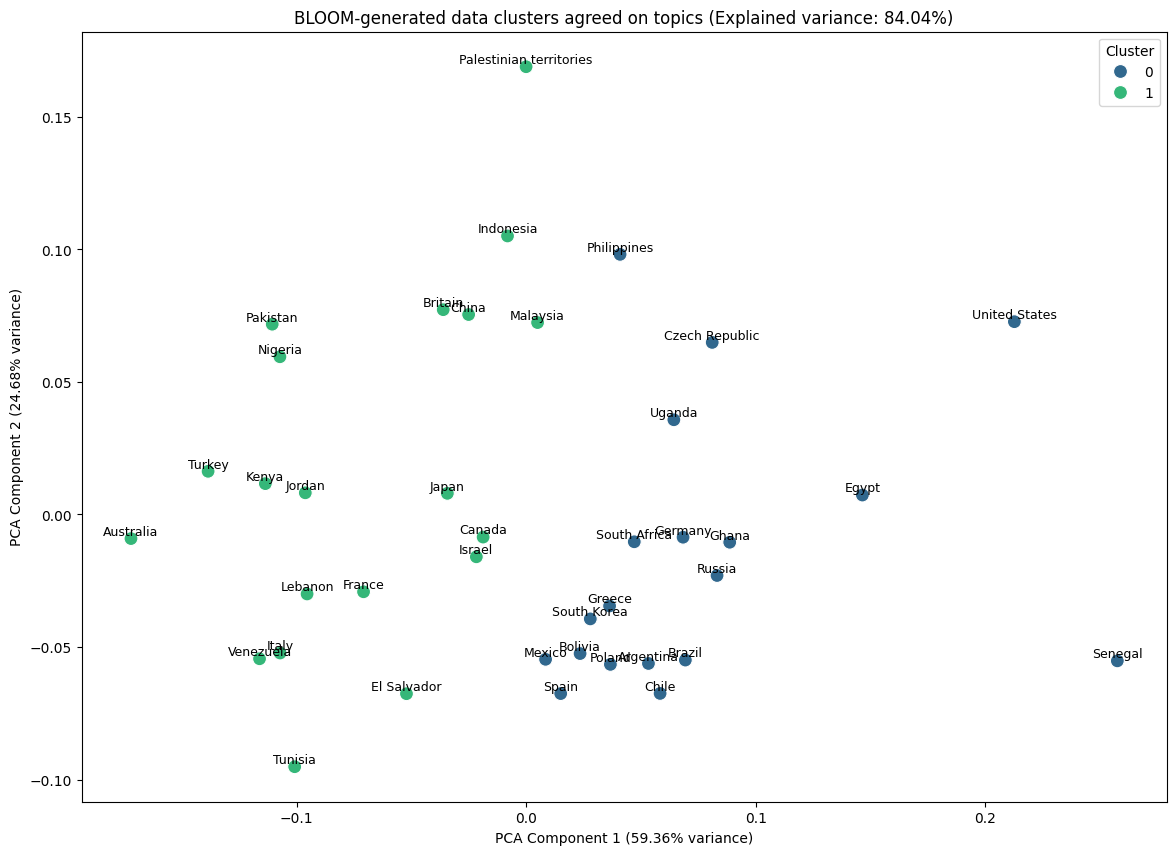

In [492]:
agreed_topics = list(most_agreed_on_PEW['topic'])

cluster_and_compare(PEW_preprocessed_df[agreed_topics], 'PEW', models, 'agreed on topics')

## Part 3. Probing the model directly on similarities/differences between stances on topics

### Defining functions

#### Finding cluster per topic

In [493]:
# improved functie met elbow method geïntegreerd

def calculate_wcss(data, clusters):
    """Calculate within-cluster sum of squares for hierarchical clustering."""
    wcss = []
    for cluster in np.unique(clusters):
        cluster_points = data[clusters == cluster]
        centroid = np.mean(cluster_points, axis=0)
        wcss.append(np.sum((cluster_points - centroid) ** 2))
    return np.sum(wcss)

def find_clusters_per_topic(preprocessed_df, topic):

    print(f"Clustering for topic {topic}: \n")

    topic_df = preprocessed_df[[topic]]

    # Convert the df to a 2D array for clustering
    data_array = topic_df.values

    # Hierarchical clustering
    Z = linkage(data_array, method='ward')

    # Plot dendrogram
    plt.figure(figsize=(12, 4))
    dendrogram(Z, labels=topic_df.index.to_list(), leaf_rotation=90, leaf_font_size=10)
    plt.title(f'Hierarchical Clustering Dendrogram for moral scores on {topic}')
    plt.xlabel('Country')
    plt.ylabel('Distance')
    plt.show()

    # Use the elbow method to find the optimal number of clusters
    max_clusters = 10
    wcss = []
    for i in range(1, max_clusters + 1):
        clusters = fcluster(Z, i, criterion='maxclust')
        wcss.append(calculate_wcss(data_array, clusters))

    plt.figure(figsize=(12, 4))
    plt.plot(range(1, max_clusters + 1), wcss)
    plt.title('Elbow Method for Optimal Number of Clusters (Hierarchical)')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

    # Automatically find the elbow point
    kl = KneeLocator(range(1, max_clusters + 1), wcss, curve='convex', direction='decreasing')
    optimal_clusters = kl.elbow

    if optimal_clusters is None:
        optimal_clusters = 2  # Default to 2 if no clear elbow is found
        print("No clear elbow found. Defaulting to 2 clusters.")
    else:
        print(f"Optimal number of clusters: {optimal_clusters}")

    # Apply hierarchical clustering with the optimal number of clusters
    clusters = fcluster(Z, optimal_clusters, criterion='maxclust')

    # Create df to show which country belongs to which cluster
    cluster_df = pd.DataFrame({'Country': topic_df.index, f'Cluster opinion on {topic}': clusters})

    # Add averages for clusters to estimate their moral attitude on the topic
    cluster_averages = topic_df.groupby(clusters).mean()
    cluster_df = cluster_df.merge(cluster_averages, left_on=f'Cluster opinion on {topic}', right_index=True, suffixes=('', '_avg'))

    # Calculate differences between clusters based on their averages
    cluster_pairs = list(itertools.combinations(cluster_averages.index, 2))
    differences = [(pair, abs(cluster_averages.loc[pair[0]] - cluster_averages.loc[pair[1]]).values[0]) for pair in cluster_pairs]

    # Sort differences by absolute value in descending order
    sorted_pairs = sorted(differences, key=lambda x: x[1], reverse=True)

    # Take the pair with the maximum difference
    most_different_pair, max_difference = sorted_pairs[0]

    # Extract the two clusters involved in the most different pair
    most_different_clusters = list(most_different_pair)

    # Print the moral score averages for the most different clusters
    average_cluster1 = cluster_averages.loc[most_different_clusters[0], topic]
    average_cluster2 = cluster_averages.loc[most_different_clusters[1], topic]

    print(f"Two most different clusters: {most_different_clusters}")
    print(f"Average moral score for first cluster: {round(average_cluster1, 3)}")
    print(f"Average moral score for second cluster: {round(average_cluster2, 3)}")

    print("\n")

    # # Print sizes of the most different clusters
    # unique_clusters, cluster_sizes = np.unique(clusters, return_counts=True)
    # for cluster in most_different_clusters:
    #     print(f"Cluster {cluster} size: {cluster_sizes[cluster - 1]} countries")

    return cluster_df, cluster_averages, most_different_clusters, average_cluster1, average_cluster2

#### Generating prompts per topic and the clusters for that topic

In [494]:
#### ***** VERSION WITH RANDOM TRIAL CLUSTER REPRESENTATIVES ***** ####

# Set the random seed for reproducibility
random.seed(42)
np.random.seed(42)


def generate_topic_prompts(topic, topic_clusters, most_different_clusters):
    intra_cluster_prompts = []
    inter_cluster_prompts = []

    # Choose two random representatives from each of the most different clusters
    representatives = {}
    for cluster in most_different_clusters:
        cluster_data = topic_clusters[topic_clusters[f'Cluster opinion on {topic}'] == cluster]
        countries = cluster_data['Country'].tolist()

        if len(countries) >= 2:
            representative_pair = random.sample(countries, 2)
            representatives[cluster] = representative_pair

    # Generate intra-cluster prompts
    prompt_formats = [
        #[f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are the same.", f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are different."],
        [f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are similar.", f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are dissimilar."],
        [f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are alike.", f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are unalike."],
        [f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are aligned.", f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are misaligned."]

    ]
    for cluster, countries in representatives.items():
        for format_pair in prompt_formats:
            prompt = [format_pair[0].format(countries[0], countries[1]), format_pair[1].format(countries[0], countries[1])]
            intra_cluster_prompts.append(prompt)

    # Generate prompts for inter-cluster comparisons between the most different clusters
    if len(representatives) == 2:
        cluster1, cluster2 = most_different_clusters
        countries1 = representatives[cluster1]
        countries2 = representatives[cluster2]

        # Generate inter-cluster prompts
        prompt_formats = [
            #[f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are the same.", f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are different."],
            [f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are similar.", f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are dissimilar."],
            [f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are alike.", f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are unalike."],
            [f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are aligned.", f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are misaligned."]
        ]
        for format_pair in prompt_formats:
            prompt1 = [format_pair[0].format(countries1[0], countries2[0]), format_pair[1].format(countries1[0], countries2[0])]
            prompt2 = [format_pair[0].format(countries1[1], countries2[1]), format_pair[1].format(countries1[1], countries2[1])]
            inter_cluster_prompts.extend([prompt1, prompt2])

    return intra_cluster_prompts, inter_cluster_prompts

In [495]:
# #### ****** VERSION EXHAUSTIVELY GOING OVER ALL POSSIBLE INTRA- AND INTERCLUSTER COMBINATIONS ****** ####

# # unfortunately, the computational resources available were too limited to carry out this exhaustive method

# def generate_topic_prompts(topic, topic_clusters, most_different_clusters):
#     intra_cluster_prompts = []
#     inter_cluster_prompts = []

#     # Step 2: Generate prompts for intra-cluster comparisons within the most different clusters
#     for cluster in most_different_clusters:
#         cluster_data = topic_clusters[topic_clusters[f'Cluster opinion on {topic}'] == cluster]
#         countries = cluster_data['Country'].tolist()

#         # Generate intra-cluster prompts
#         pairs = list(itertools.combinations(countries, 2))
#         prompt_formats = [
#           #[f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are the same.", f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are different."],
#           [f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are similar.", f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are dissimilar."],
#           [f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are alike.", f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are unalike."],
#           [f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are aligned.", f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are misaligned."]
#         ]
#         for country1, country2 in pairs:
#             for prompt_format in prompt_formats:
#                 prompt = [prompt_format[0].format(country1, country2), prompt_format[1].format(country1, country2)]
#                 intra_cluster_prompts.append(prompt)

#     # Step 3: Generate prompts for inter-cluster comparisons between the most different clusters
#     cluster1_data = topic_clusters[topic_clusters[f'Cluster opinion on {topic}'] == most_different_clusters[0]]
#     cluster2_data = topic_clusters[topic_clusters[f'Cluster opinion on {topic}'] == most_different_clusters[1]]

#     combinations = list(itertools.product(cluster1_data['Country'].tolist(), cluster2_data['Country'].tolist()))

#     prompt_formats = [
#         #[f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are the same.", f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are different."],
#         [f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are similar.", f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are dissimilar."],
#         [f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are alike.", f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are unalike."],
#         [f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are aligned.", f"Regarding the morality of {topic}, the judgments of people in {{}} and {{}} are misaligned."]
#     ]
#     for country1, country2 in combinations:
#         for prompt_format in prompt_formats:
#           prompt = [prompt_format[0].format(country1, country2), prompt_format[1].format(country1, country2)]
#           inter_cluster_prompts.append(prompt)

#     return intra_cluster_prompts, inter_cluster_prompts

#### Get log probabilties functions

In [496]:
# get result df for direct probing results
# original code with Hadi's suggestions incorporated:

def get_log_probabilities(prompts, model, tokenizer, use_cuda=False):
    log_probs = []

    for prompt in prompts:
        # Tokenize the prompt
        input_ids = tokenizer.encode(prompt, return_tensors='pt')

        # Move input to GPU if available
        if use_cuda:
            input_ids = input_ids.to('cuda')

        # Generate model output
        with torch.no_grad():
            outputs = model(input_ids)
            logits = outputs.logits

        # Calculate log probabilities for the last token
        log_probs.append(torch.log_softmax(logits[0, -1], dim=0))

    return log_probs

def get_average_log_probabilities(prompts, model, tokenizer, use_cuda=False):

    all_log_probs = []

    log_probs = get_log_probabilities(prompts, model, tokenizer, use_cuda)
    all_log_probs.append(log_probs)

    # Average the log probabilities across different prompt sets
    avg_log_probs_same = np.mean([log_probs[0].numpy() for log_probs in all_log_probs], axis=0)
    avg_log_probs_different = np.mean([log_probs[1].numpy() for log_probs in all_log_probs], axis=0)

    return avg_log_probs_same, avg_log_probs_different


#### Get df for direct probing results

In [497]:
#### ***** VERSION WITH RANDOM TRIAL CLUSTER REPRESENTATIVES ***** ####

def get_direct_probing_results(dataset, topic, topic_clusters, most_different_clusters, model_name, trials=1):
    direct_probing_results = []

    if model_name == 'gpt2':
        model = GPT2LMHeadModel.from_pretrained('gpt2')
        tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    elif model_name == 'gpt2-medium':
        model = GPT2LMHeadModel.from_pretrained('gpt2-medium')
        tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium')
    elif model_name == 'gpt2-large':
        model = GPT2LMHeadModel.from_pretrained('gpt2-large')
        tokenizer = GPT2Tokenizer.from_pretrained('gpt2-large')
    elif model_name == 'QWEN':
        model = AutoModelForCausalLM.from_pretrained('Qwen/Qwen1.5-0.5B')
        tokenizer = AutoTokenizer.from_pretrained('Qwen/Qwen1.5-0.5B')
    elif model_name == 'OPT-125':
        model = AutoModelForCausalLM.from_pretrained('facebook/opt-125m')
        tokenizer = AutoTokenizer.from_pretrained('facebook/opt-125m')
    elif model_name == 'BLOOM':
        tokenizer = AutoTokenizer.from_pretrained("bigscience/bloomz-560m")
        model = AutoModelForCausalLM.from_pretrained("bigscience/bloomz-560m")

    for _ in range(trials):

        #print(f"TRIAL NUMBER {_} \n")

        intra_cluster_prompts, inter_cluster_prompts = generate_topic_prompts(topic, topic_clusters, most_different_clusters)

        for combination in intra_cluster_prompts:
            avg_log_probs_same, avg_log_probs_different = get_average_log_probabilities(combination, model, tokenizer, use_cuda=False)
            if avg_log_probs_same.mean() > avg_log_probs_different.mean():
                result = "similar"
            elif avg_log_probs_same.mean() < avg_log_probs_different.mean():
                result = "dissimilar"
            else:
                result = "equal"

            row = {
                "topic": topic,
                "combination": combination,
                "average log prob in favor of 'similar'": avg_log_probs_same.mean(),
                "average log prob in favor of 'dissimilar'": avg_log_probs_different.mean(),
                f"{dataset} cluster judgement": "similar",
                "model judgement": result
            }

            direct_probing_results.append(row)
            #print(row)

        for combination in inter_cluster_prompts:
            avg_log_probs_same, avg_log_probs_different = get_average_log_probabilities(combination, model, tokenizer, use_cuda=False)
            if avg_log_probs_same.mean() > avg_log_probs_different.mean():
                result = "similar"
            elif avg_log_probs_same.mean() < avg_log_probs_different.mean():
                result = "dissimilar"
            else:
                result = "equal"

            row = {
                "topic": topic,
                "combination": combination,
                "average log prob in favor of 'similar'": avg_log_probs_same.mean(),
                "average log prob in favor of 'dissimilar'": avg_log_probs_different.mean(),
                f"{dataset} cluster judgement": "dissimilar",
                "model judgement": result
            }

            direct_probing_results.append(row)
            #print(row)

    # Creating DataFrame
    direct_probing_results_df = pd.DataFrame(direct_probing_results)

    return direct_probing_results_df

In [498]:
# ### ****** VERSION EXHAUSTIVELY GOING OVER ALL POSSIBLE INTRA- AND INTERCLUSTER COMBINATIONS ****** ####

# # unfortunately, the computational resources available were too limited to carry out this exhaustive method

# def get_direct_probing_results(dataset, topic, topic_clusters, most_different_clusters, model_name):
#     direct_probing_results = []

#     if model_name == 'gpt2':
#         model = GPT2LMHeadModel.from_pretrained('gpt2')
#         tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
#     elif model_name == 'gpt2-medium':
#         model = GPT2LMHeadModel.from_pretrained('gpt2-medium')
#         tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium')
#     elif model_name == 'gpt2-large':
#         model = GPT2LMHeadModel.from_pretrained('gpt2-large')
#         tokenizer = GPT2Tokenizer.from_pretrained('gpt2-large')
#     elif model_name == 'QWEN':
#         model = AutoModelForCausalLM.from_pretrained('Qwen/Qwen1.5-0.5B')
#         tokenizer = AutoTokenizer.from_pretrained('Qwen/Qwen1.5-0.5B')
#     elif model_name == 'OPT-125':
#         model = AutoModelForCausalLM.from_pretrained('facebook/opt-125m')
#         tokenizer = AutoTokenizer.from_pretrained('facebook/opt-125m')
#     elif model_name == 'BLOOM':
#         tokenizer = AutoTokenizer.from_pretrained("bigscience/bloomz-560m")
#         model = AutoModelForCausalLM.from_pretrained("bigscience/bloomz-560m")

#     intra_cluster_prompts, inter_cluster_prompts = generate_topic_prompts(topic, topic_clusters, most_different_clusters)

#     # Get average log probabilities for intra-cluster prompts
#     for combination in intra_cluster_prompts:
#         avg_log_probs_same, avg_log_probs_different = get_average_log_probabilities(combination, model, tokenizer, use_cuda=False)
#         if avg_log_probs_same.mean() > avg_log_probs_different.mean():
#             result = "similar"
#         elif avg_log_probs_same.mean() < avg_log_probs_different.mean():
#             result = "dissimilar"
#         else:
#             result = "equal"

#         row = {
#             "topic": topic,
#             "combination": combination,
#             "average log prob in favor of 'similar'": avg_log_probs_same.mean(),
#             "average log prob in favor of 'dissimilar'": avg_log_probs_different.mean(),
#             f"{dataset} cluster judgement": "similar",
#             "model judgement": result
#         }

#         direct_probing_results.append(row)

#     # Get average log probabilities for inter-cluster prompts
#     for combination in inter_cluster_prompts:
#         avg_log_probs_same, avg_log_probs_different = get_average_log_probabilities(combination, model, tokenizer, use_cuda=False)
#         if avg_log_probs_same.mean() > avg_log_probs_different.mean():
#             result = "similar"
#         elif avg_log_probs_same.mean() < avg_log_probs_different.mean():
#             result = "dissimilar"
#         else:
#             result = "equal"

#         row = {
#             "topic": topic,
#             "combination": combination,
#             "average log prob in favor of 'similar'": avg_log_probs_same.mean(),
#             "average log prob in favor of 'dissimilar'": avg_log_probs_different.mean(),
#             f"{dataset} cluster judgement": "dissimilar",
#             "model judgement": result
#         }

#         direct_probing_results.append(row)

#     direct_probing_results_df = pd.DataFrame(direct_probing_results)

#     return direct_probing_results_df


#### Evaluation metrics function

In [499]:
def evaluate_results(dataset, df):

    # Exclude rows where 'model judgement' is 'equal'
    df = df[df['model judgement'] != 'equal']

    # precision, recall, and F1 scores
    y_true = df[f'{dataset} cluster judgement']
    y_pred = df['model judgement']

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label='similar', average='binary')
    recall = recall_score(y_true, y_pred, pos_label='similar', average='binary')
    f1 = f1_score(y_true, y_pred, pos_label='similar', average='binary')
    report = classification_report(y_true, y_pred, target_names=['similar', 'dissimilar'])

    print(f"Accuracy: {round(accuracy, 3)}")
    print(f'Precision: {round(precision, 3)}')
    print(f'Recall: {round(recall, 3)}')
    print(f'F1 Score: {round(f1, 3)}')
    print(f"Classification report \n: {report}")

    # chi-squared test
    contingency_table = pd.crosstab(df[f'{dataset} cluster judgement'], df['model judgement'])
    chi2, p, _, _ = chi2_contingency(contingency_table)

    print(f'Chi-squared test statistic: {round(chi2, 3)}')
    print(f'p-value: {round(p, 3)}')
    print("\n")

### Perform direct comparative probing experiment

Going over all topics & performing the probing experiment. We might want to make comparisons for the most controversial and most agreeable topics (according) regarding how they are 'classified' according to these prompts. This also reminds me: look into, how to better assess: due to finegrained scores from decoder model, or classification and maybe an encoder model?

In [500]:
models = ['gpt2-medium', 'gpt2-large', 'OPT-125', 'QWEN', 'BLOOM']

In [501]:
def initialize_clusters_and_averages(dataset_df, topic_list):
    topic_clusters_dict = {}
    most_different_clusters_dict = {}
    averages_cluster1 = []
    averages_cluster2 = []

    for topic in topic_list:
        topic_clusters_df, cluster_averages, most_different_clusters, average_cluster1, average_cluster2 = find_clusters_per_topic(dataset_df, topic)
        topic_clusters_dict[topic] = topic_clusters_df
        most_different_clusters_dict[topic] = most_different_clusters
        averages_cluster1.append(average_cluster1)
        averages_cluster2.append(average_cluster2)

    return topic_clusters_dict, most_different_clusters_dict, averages_cluster1, averages_cluster2

def get_results_for_model(dataset, model_name, topic_clusters_dict, most_different_clusters_dict):
    df = pd.DataFrame()
    for topic, clusters_df in topic_clusters_dict.items():
        print(f"On topic: {topic}")
        most_different_clusters = most_different_clusters_dict[topic]
        topic_results_df = get_direct_probing_results(dataset, topic, clusters_df, most_different_clusters, model_name)
        df = pd.concat([df, topic_results_df], ignore_index=True)
    return df

def plot_averages_for_clusters(topic_list, averages_cluster1, averages_cluster2, dataset_name):
    x = np.arange(len(topic_list))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(14, 8))
    rects1 = ax.bar(x - width/2, averages_cluster1, width, label='First cluster')
    rects2 = ax.bar(x + width/2, averages_cluster2, width, label='Second cluster')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Topics')
    ax.set_ylabel('Average moral score')
    ax.set_title(f'Average moral scores for the two most differing clusters per topic ({dataset_name})')
    ax.set_xticks(x)
    ax.set_xticklabels(topic_list, rotation=90)
    ax.legend()

    fig.tight_layout()
    plt.show()

def process_dataset(dataset_name, dataset_df, topic_list, models):
    print(f"Processing dataset: {dataset_name} \n")

    # Initialize clusters and averages
    topic_clusters_dict, most_different_clusters_dict, averages_cluster1, averages_cluster2 = initialize_clusters_and_averages(dataset_df, topic_list)

    # Plot averages
    plot_averages_for_clusters(topic_list, averages_cluster1, averages_cluster2, dataset_name)

    print("\n")

    # Process each model
    for model in models:
        print(f"Direct comparative probing results for {model}:")
        model_df = get_results_for_model(dataset_name, model, topic_clusters_dict, most_different_clusters_dict)
        display(model_df)
        evaluate_results(dataset_name, model_df)
        ##optional: if we want to export & save the result df, uncomment the line below
        #model_df.to_csv(f'/content/drive/MyDrive/MSc Applied Data Science/ADS thesis Mijntje/Mijn data/{model}_{dataset_name}_directprobing.csv', index=False)

#### WVS

In [502]:
# Process WVS dataset
WVS_topic_list = ['claiming government benefits to which you are not entitled', 'avoiding a fare on public transport', 'stealing property', 'cheating on taxes', 'someone accepting a bribe in the course of their duties', 'homosexuality', 'prostitution', \
              'abortion', 'divorce', 'sex before marriage', 'suicide', 'euthanasia', 'for a man to beat his wife', 'parents beating children', 'violence against other people', 'terrorism as a political, ideological or religious mean', 'having casual sex', 'political violence', 'death penalty']

process_dataset('WVS', WVS_preprocessed_df, WVS_topic_list, models)

Output hidden; open in https://colab.research.google.com to view.

#### PEW

In [ ]:
# Process PEW dataset
PEW_topic_list = ['drinking alcohol', 'gambling', 'getting a divorce', 'having an abortion', 'homosexuality', 'married people having an affair', 'sex between unmarried adults', 'using contraceptives']

process_dataset('PEW', PEW_preprocessed_df, PEW_topic_list, models)